Hier werden die Ergebnisse eingelesen und ausgewertet

In [1]:
#Import der notwendigen Bibliotheken, Installation mit pip bereits erfolgt

import yfinance as yf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import minimize
import math
import random
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
import riskfolio as rp
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import squareform
from riskfolio import HCPortfolio as hc

In [2]:
def gesamt_return(returns):

    total = np.cumprod(1 + returns)
    
    return total

In [3]:
def portfolio_return (returns):
    
    pf_return = returns.mean()
    
    return pf_return

In [4]:
def portfolio_variance (returns):
    
    pf_var = np.var(returns)
    
    return pf_var

In [5]:
def portfolio_volatility (returns):
    variance = portfolio_variance(returns)
    volatility = np.sqrt(variance)
    
    return volatility

In [6]:
def sharpe_ratio (returns):
    pf_return = portfolio_return (returns)
    volatility = portfolio_volatility (returns)
    zins_risikofrei = 0
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [7]:
def sharpe_ratio_one (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.01
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [8]:
def sharpe_ratio_two (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.02
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [9]:
def sortino_ratio (returns): 
    
    zins_risikofrei = 0
        
    temp = (np.minimum(0, returns - zins_risikofrei))**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [10]:
def sortino_ratio_one (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.01
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [11]:
def sortino_ratio_two (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.02
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [12]:
def maximum_drawdown (returns):
    
    returns_kumuliert = (1 + returns).cumprod()
    hochpunkte = returns_kumuliert.cummax()
    
    drawdowns = (returns_kumuliert - hochpunkte) / hochpunkte
    max_drawdown = drawdowns.min()
    
    #print(drawdowns)
    return max_drawdown

In [13]:
def calmar_ratio (returns):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    max_drawdown = maximum_drawdown(returns)
    
    calmar_ratio = annualized_return / (-max_drawdown)
    
    return calmar_ratio

In [14]:
def calmar_ratio_total (returns):
    total_return = (1 + returns).prod() - 1
    
    max_drawdown = maximum_drawdown(returns)
    calmar_ratio_gesamt = total_return / (-max_drawdown)
    
    return calmar_ratio_gesamt

In [15]:
def value_at_risk_func(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = np.percentile(sorted_daily_returns, 100*0.05)
    return value_at_risk

In [16]:
#https://github.com/malctaylor15/VaR-and-Expected-Shortfall-Python/blob/master/Expected%20Shortfall%20and%20Value%20at%20Risk.ipynb

def expected_shortfall(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = value_at_risk_func(returns)
    
    expected_shortfall = sorted_daily_returns[sorted_daily_returns <= value_at_risk].mean()
    
    return expected_shortfall

## Auswertung S&P 500 Voll

In [17]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500 = pd.read_csv(
    'returnsJSE_neu_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [18]:
df_SP500.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.000033          0.000705                 0.000391   
1     2006-06-02          0.017961          0.005881                 0.008007   
2     2006-06-05          0.000017         -0.003898                -0.003364   
3     2006-06-06         -0.033173         -0.016104                -0.020517   
4     2006-06-07         -0.023522         -0.025723                -0.023729   
...          ...               ...               ...                      ...   
4905  2025-05-26          0.004559          0.002929                 0.002356   
4906  2025-05-27          0.000705          0.000401                -0.001830   
4907  2025-05-28          0.000644          0.004763                 0.005638   
4908  2025-05-29          0.008966         -0.001394                 0.001425   
4909  2025-05-30          0.003385          0.000332                 0.000241

In [19]:
df_SP500.head()

Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0  2006-06-01          0.000033          0.000705                 0.000391   
1  2006-06-02          0.017961          0.005881                 0.008007   
2  2006-06-05          0.000017         -0.003898                -0.003364   
3  2006-06-06         -0.033173         -0.016104                -0.020517   
4  2006-06-07         -0.023522         -0.025723                -0.023729   

   Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
0            0.001299                 0.000945  0.001816  0.004776  
1            0.016920                 0.014556  0.012557  0.022760  
2           -0.000357                -0.000420 -0.000836 -0.001820  
3           -0.031555                -0.029679 -0.025549 -0.034661  
4           -0.023612                -0.024112 -0.023751 -0.021412

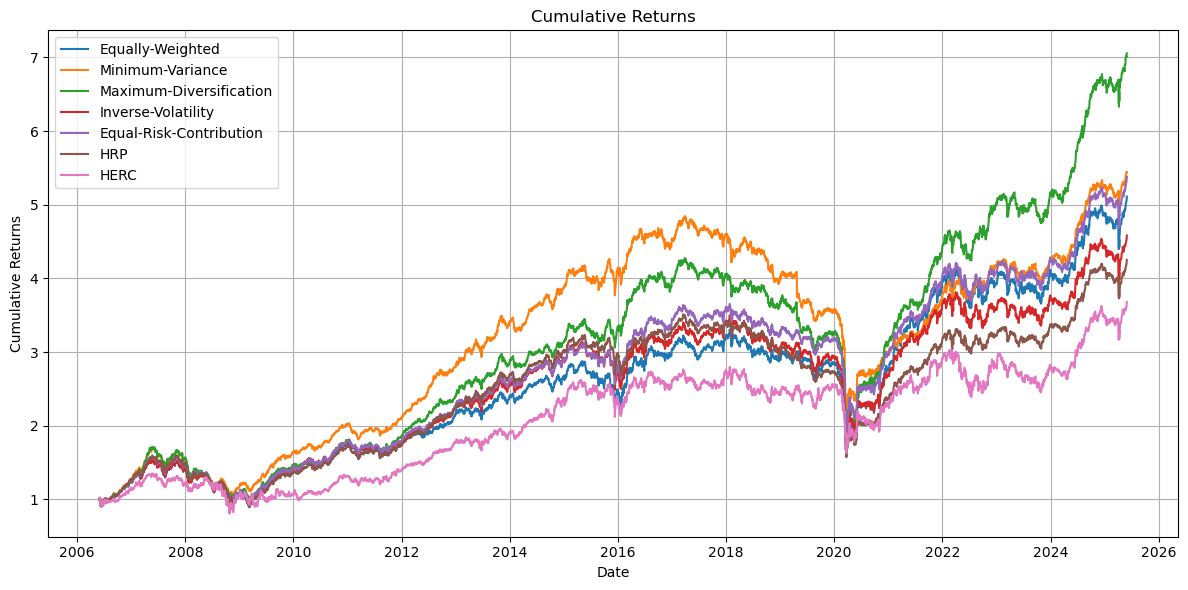

In [20]:
df_SP500["Date"] = pd.to_datetime(df_SP500["Date"])

#Date-Spalte als Index setzen
df_SP500 = df_SP500.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
letzte_returns = kumulative_returns.iloc[-1]
print(letzte_returns)

Equally-Weighted           5.110612
Minimum-Variance           5.440977
Maximum-Diversification    7.055028
Inverse-Volatility         4.582239
Equal-Risk-Contribution    5.377441
HRP                        4.251723
HERC                       3.678550
Name: 2025-05-30 00:00:00, dtype: float64


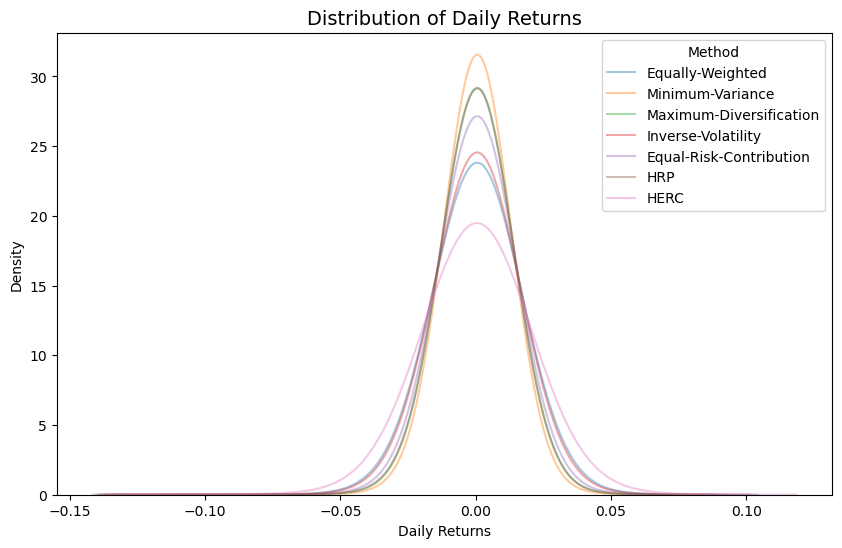

In [22]:
plt.figure(figsize=(10, 6))
for col in df_SP500.columns:
    sb.kdeplot(df_SP500[col], label=col, fill=False, alpha=0.4, bw_adjust=9)

plt.title("Distribution of Daily Returns", fontsize=14)
plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.legend(title="Method")
plt.show()

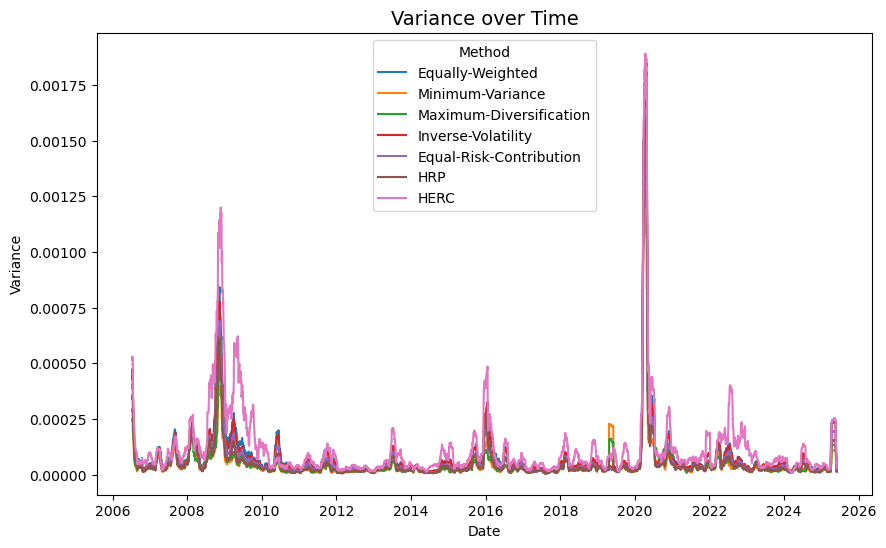

In [23]:
rollierende_varianz = df_SP500.rolling(window=30).var()

plt.figure(figsize=(10, 6))
for col in rollierende_varianz.columns:
    plt.plot(rollierende_varianz.index, rollierende_varianz[col], label=col)

plt.title("Variance over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend(title="Method")
plt.show()

In [24]:
#Letzten Wert jedes Jahres extrahieren
df_kum_endwerte = kumulative_returns.resample('Y').last()

#Jahr als Spalte
df_kum_endwerte.index = df_kum_endwerte.index.year
df_kum_endwerte.index.name = "Year"

df_kum_endwerte.head()

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Year                                                                
2006          1.255335          1.280461                 1.243361   
2007          1.412143          1.568348                 1.568771   
2008          1.072537          1.179071                 1.082727   
2009          1.423659          1.649995                 1.472878   
2010          1.760335          2.012308                 1.804243   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Year                                                                   
2006            1.258813                 1.258544  1.272740  1.153186  
2007            1.419679                 1.473172  1.492450  1.199814  
2008            1.089995                 1.098873  1.059188  1.058969  
2009            1.425065                 1.436455  1.374201  1.069967  
2010            1.779895                 1.790702  1.711776  1.323218

In [25]:
#jährliche kumulierte Rendite berechnen
jährlich_kum_returns = (1 + df_SP500).resample('Y').prod() - 1

#Jahr als Spalte
jährlich_kum_returns.index = jährlich_kum_returns.index.year
jährlich_kum_returns.index.name = "Year"

jährlich_kum_returns.head()

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Year                                                                
2006          0.255335          0.280461                 0.243361   
2007          0.124913          0.224831                 0.261718   
2008         -0.240490         -0.248208                -0.309824   
2009          0.327376          0.399403                 0.360340   
2010          0.236487          0.219584                 0.224978   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Year                                                                   
2006            0.258813                 0.258544  0.272740  0.153186  
2007            0.127792                 0.170537  0.172628  0.040434  
2008           -0.232225                -0.254077 -0.290303 -0.117389  
2009            0.307405                 0.307208  0.297410  0.010385  
2010            0.248993                 0.246612  0.245652  0.236691

In [26]:
from IPython.display import display, HTML

display(HTML(jährlich_kum_returns.to_html()))

In [27]:
reorganisiert = jährlich_kum_returns.reset_index().melt(id_vars="Year", var_name="Strategy", value_name="Returns")
reorganisiert.head()

Year          Strategy   Returns
0  2006  Equally-Weighted  0.255335
1  2007  Equally-Weighted  0.124913
2  2008  Equally-Weighted -0.240490
3  2009  Equally-Weighted  0.327376
4  2010  Equally-Weighted  0.236487

In [28]:
import plotly.express as px

fig = px.bar(reorganisiert, 
             x="Year", y="Returns", color="Strategy", 
             barmode="group",
             text="Returns",
             title="Yearly Cumulative Returns",
             color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(yaxis_tickformat='.0%', xaxis={'type': 'category'})
fig.show()

In [29]:
#jährliche vola

jährliche_vola = (df_SP500.groupby(df_SP500.index.year).std()
    .apply(lambda x: x * np.sqrt(252))
    * 100
)

print(jährliche_vola.round(2))

      Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006             18.22             13.50                    14.40   
2007             13.69             11.77                    13.37   
2008             24.52             18.35                    19.20   
2009             17.32             11.42                    12.24   
2010             11.53              6.96                     7.43   
2011             11.87              7.12                     8.17   
2012              7.94              6.05                     6.26   
2013             10.91              8.05                     8.45   
2014              8.79              6.55                     6.97   
2015             13.39              9.82                     9.88   
2016             14.02              9.16                     9.93   
2017              7.76              6.04                     6.62   
2018             10.84            

<Figure size 1000x600 with 0 Axes>

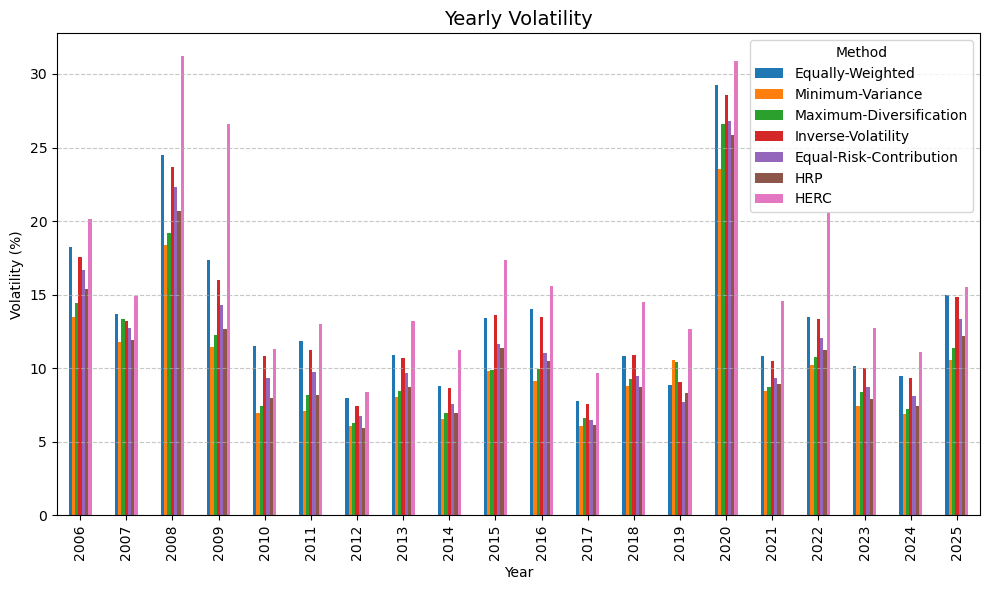

In [30]:
plt.figure(figsize=(10, 6))
jährliche_vola.plot(kind="bar", figsize=(10, 6))

plt.title("Yearly Volatility", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Volatility (%)")
plt.legend(title="Method")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Sharpe Ratio

In [31]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sharpe_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [32]:
sharpe_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.182618          3.136853                 2.605754   
2007          0.910366          1.745391                 1.768711   
2008         -0.970536         -1.423130                -1.785442   
2009          1.687395          2.937544                 2.522394   
2010          1.839421          2.794959                 2.680909   
2011         -0.031028          0.627222                 0.380066   
2012          2.623623          4.597231                 3.977722   
2013          1.025757          2.429621                 2.107560   
2014          1.209907          1.931879                 1.257412   
2015         -0.465055          0.696449                 0.687221   
2016          1.466068          1.024207                 1.783110   
2017          0.829830          0.208583                 0.237608   
20

In [33]:
#Durchschnitt
sharpe_durchschnitt = sharpe_jahresweise.mean(axis=1)

sharpe_durchschnitt = sharpe_durchschnitt.to_frame(name="Sharpe_Mittelwert")

sharpe_durchschnitt.info

<bound method DataFrame.info of       Sharpe_Mittelwert
Date                   
2006           2.370884
2007           1.194004
2008          -1.151477
2009           1.859410
2010           2.324645
2011           0.245158
2012           3.521806
2013           1.584011
2014           1.531666
2015           0.065447
2016           1.287515
2017           0.562744
2018          -1.017365
2019          -0.610617
2020          -0.190045
2021           2.991370
2022           0.321542
2023           0.482417
2024           2.508118
2025           0.832468>

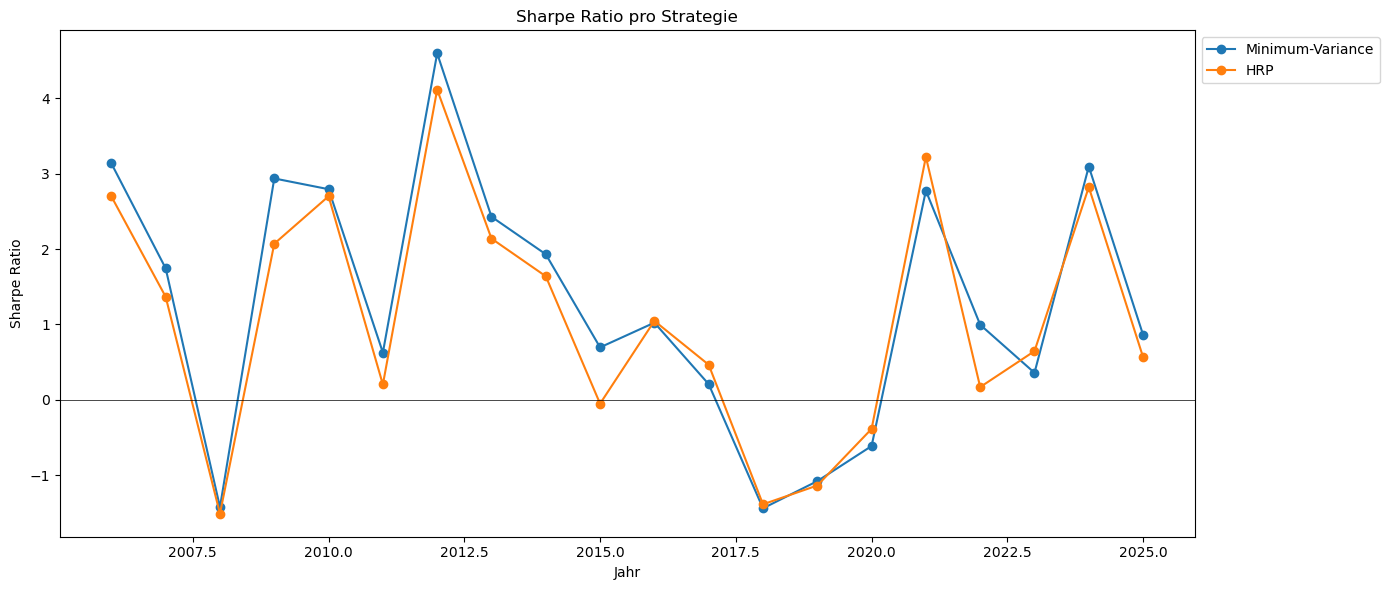

In [34]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

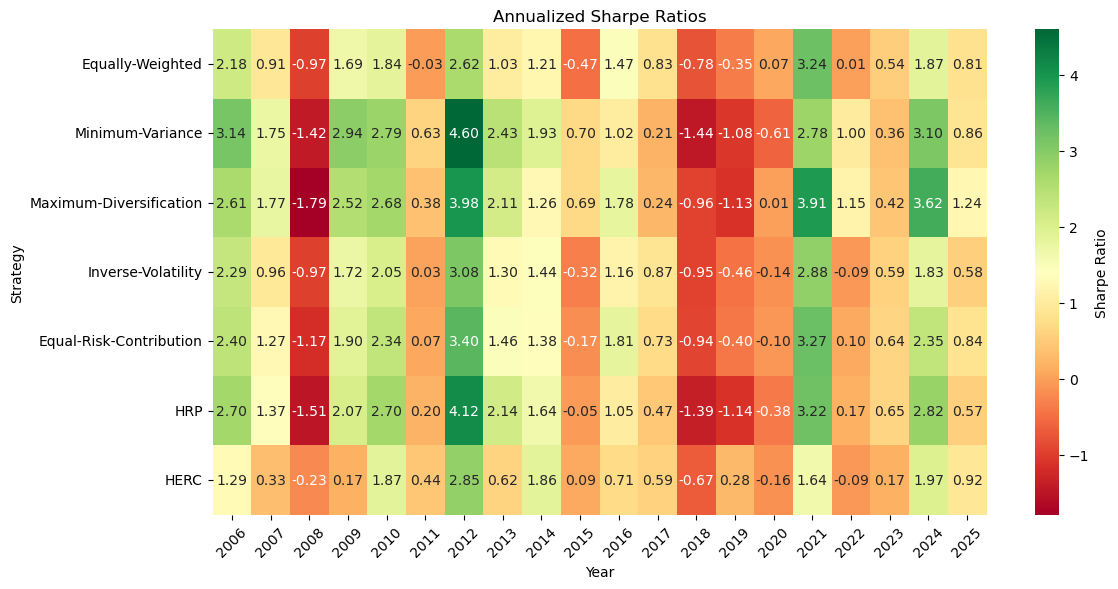

In [35]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualized Sharpe Ratios")
plt.xlabel("Year")
plt.ylabel("Strategy")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
#Simulation mit synthetischen Werten

np.random.seed(42)

#Simulation: 20 Jahre, 252 Handelstage pro Jahr
years = 20
days_per_year = 252
mu_daily = 0.0005       
sigma_daily = 0.01      

#Simulierte tägliche Renditen (normalverteilt)
daily_returns = np.random.normal(loc=mu_daily, scale=sigma_daily, size=(days_per_year*years,))

#Datum-Index erstellen
dates = pd.date_range(start="2000-01-01", periods=days_per_year*years, freq='B')
df_sim = pd.DataFrame(daily_returns, index=dates, columns=['Strategy'])

#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    return (returns_daily.mean() / returns_daily.std()) * np.sqrt(days_per_year)

#Sharpe Ratios pro Jahr berechnen
sharpe_by_year = df_sim.groupby(df_sim.index.year).apply(lambda x: x.apply(sharpe_annual))

print(sharpe_by_year)

      Strategy
2000  0.938821
2001  0.686188
2002  0.254476
2003  3.547887
2004  1.809797
2005  2.077011
2006  1.241718
2007  0.797057
2008  1.363644
2009  0.511714
2010  2.034882
2011 -0.234316
2012  0.727365
2013  1.306639
2014 -0.508489
2015  0.455300
2016 -1.627256
2017  1.034871
2018  0.593904
2019  2.021202


In [37]:
#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
annualized_sharpe = df_SP500.apply(sharpe_annual)

print(annualized_sharpe)

Equally-Weighted           0.657068
Minimum-Variance           0.853628
Maximum-Diversification    0.912966
Inverse-Volatility         0.632077
Equal-Risk-Contribution    0.748109
HRP                        0.688922
HERC                       0.470725
dtype: float64


In [38]:
#Funktion für annualisierten Sharpe Ratio
def sharpe_total(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4910)  #4780 Handelstage

#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
total_sharpe = df_SP500.apply(sharpe_total)

print(total_sharpe)

Equally-Weighted           2.900351
Minimum-Variance           3.767983
Maximum-Diversification    4.029907
Inverse-Volatility         2.790040
Equal-Risk-Contribution    3.302215
HRP                        3.040958
HERC                       2.077820
dtype: float64


#### Sortino

In [39]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sortino_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

In [40]:
sortino_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.079217          4.695348                 3.785151   
2007          1.257997          2.414128                 2.547161   
2008         -1.298916         -1.840181                -2.271896   
2009          2.527104          4.833172                 4.042591   
2010          2.737512          4.237365                 4.114048   
2011         -0.041902          0.850689                 0.519897   
2012          3.967689          8.548039                 6.982490   
2013          1.397155          3.648111                 3.060464   
2014          1.781424          2.845852                 1.809212   
2015         -0.605926          0.962354                 0.974835   
2016          2.195466          1.462463                 2.714432   
2017          1.254059          0.287205                 0.336374   
20

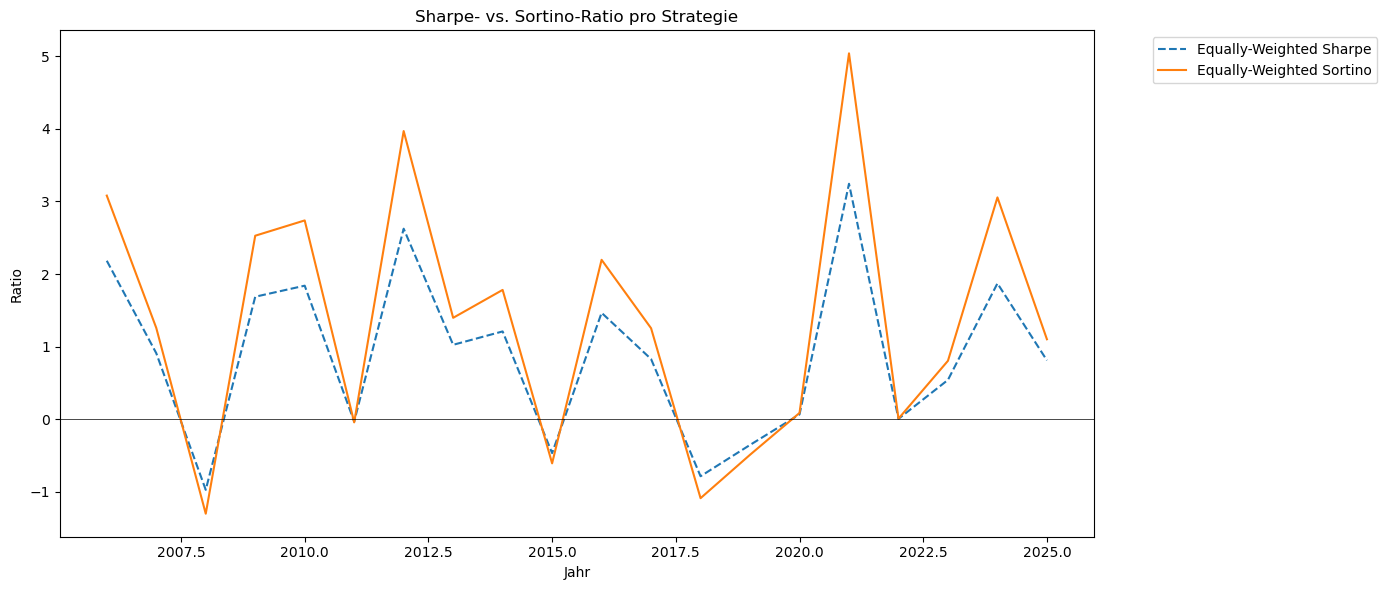

In [41]:
#Vergleich Sharpe und Sortino
strategies = sharpe_jahresweise.columns
jahre = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Equally-Weighted"

plt.plot(jahre, sharpe_jahresweise[strategie], label=f"{strategie} Sharpe", linestyle='--')
plt.plot(jahre, sortino_jahresweise[strategie], label=f"{strategie} Sortino", linestyle='-')

plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Jahr")
plt.ylabel("Ratio")
plt.title("Sharpe- vs. Sortino-Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino = df_SP500.apply(sortino_annual)

print(annualized_sortino)

Equally-Weighted           0.912107
Minimum-Variance           1.150480
Maximum-Diversification    1.251599
Inverse-Volatility         0.873110
Equal-Risk-Contribution    1.027148
HRP                        0.924589
HERC                       0.663948
dtype: float64


In [43]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4910)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino = df_SP500.apply(sortino_total)

print(gesamt_sortino)

Equally-Weighted           4.026115
Minimum-Variance           5.078314
Maximum-Diversification    5.524664
Inverse-Volatility         3.853980
Equal-Risk-Contribution    4.533915
HRP                        4.081214
HERC                       2.930720
dtype: float64


#### Maximum Drawdown

In [44]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(maximum_drawdown))

In [45]:
max_drawdown_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.111824         -0.090870                -0.103311   
2007         -0.160553         -0.152993                -0.160731   
2008         -0.376662         -0.363122                -0.393186   
2009         -0.197326         -0.095808                -0.124482   
2010         -0.075729         -0.049770                -0.047444   
2011         -0.125199         -0.108147                -0.106443   
2012         -0.040318         -0.030210                -0.032169   
2013         -0.074547         -0.075352                -0.062779   
2014         -0.080826         -0.055056                -0.057371   
2015         -0.218784         -0.115803                -0.112033   
2016         -0.083945         -0.061940                -0.066370   
2017         -0.101262         -0.085878                -0.087773   
20

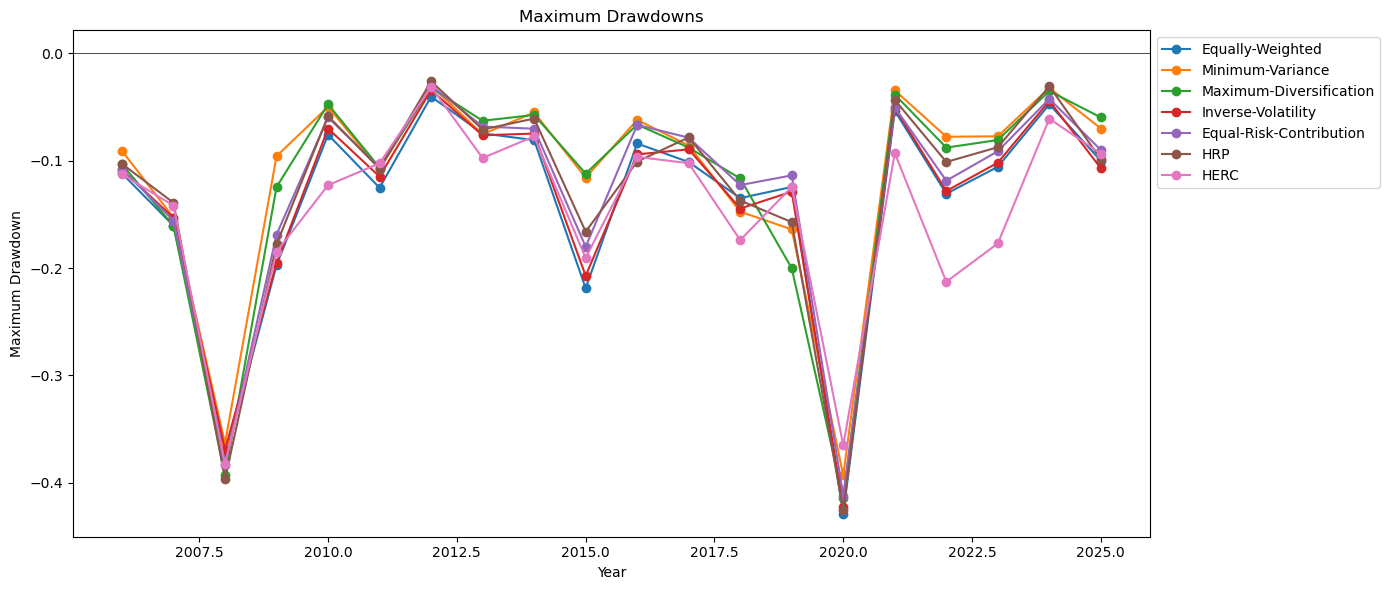

In [46]:
#Plotten der MDDs
strategien = max_drawdown_jahresweise.columns
years = max_drawdown_jahresweise.index

plt.figure(figsize=(14,6))

for strategie in strategies:
    plt.plot(years, max_drawdown_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  # Null-Linie
plt.xlabel("Year")
plt.ylabel("Maximum Drawdown")
plt.title("Maximum Drawdowns")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [47]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_total = df_SP500.apply(maximum_drawdown)

max_drawdown_total.info

<bound method Series.info of Equally-Weighted          -0.504756
Minimum-Variance          -0.551253
Maximum-Diversification   -0.549821
Inverse-Volatility        -0.513797
Equal-Risk-Contribution   -0.485350
HRP                       -0.552162
HERC                      -0.419102
dtype: float64>

#### Calmar Ratio

In [48]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(calmar_ratio))

In [49]:
calmar_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          4.127585          5.620197                 4.243227   
2007          0.758864          1.431885                 1.585967   
2008         -0.623430         -0.667514                -0.770304   
2009          1.614904          4.055065                 2.816794   
2010          3.003705          4.244785                 4.561923   
2011         -0.085008          0.397007                 0.263594   
2012          5.633631         10.503072                 8.689939   
2013          1.496645          2.807202                 3.031337   
2014          1.332254          2.398914                 1.547841   
2015         -0.313843          0.565383                 0.579547   
2016          2.569736          1.510085                 2.824849   
2017          0.623812          0.125962                 0.155071   
20

In [50]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total = df_SP500.apply(calmar_ratio)

calmar_total.info

<bound method Series.info of Equally-Weighted           0.173015
Minimum-Variance           0.164773
Maximum-Diversification    0.191832
Inverse-Volatility         0.158151
Equal-Risk-Contribution    0.185792
HRP                        0.139652
HERC                       0.164961
dtype: float64>

In [51]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total_2 = df_SP500.apply(calmar_ratio_total)

calmar_total_2.info

<bound method Series.info of Equally-Weighted            8.143756
Minimum-Variance            8.056148
Maximum-Diversification    11.012732
Inverse-Volatility          6.972089
Equal-Risk-Contribution     9.019147
HRP                         5.889076
HERC                        6.391165
dtype: float64>

#### Value at Risk

In [52]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.020351         -0.009825                -0.012059   
2007         -0.014836         -0.012262                -0.013933   
2008         -0.026224         -0.022148                -0.021387   
2009         -0.018354         -0.010444                -0.010854   
2010         -0.011905         -0.006577                -0.007345   
2011         -0.012818         -0.007589                -0.008523   
2012         -0.008461         -0.004762                -0.005216   
2013         -0.012782         -0.007922                -0.008782   
2014         -0.008447         -0.006597                -0.007059   
2015         -0.014589         -0.007678                -0.008137   
2016         -0.013721         -0.009765                -0.010082   
2017         -0.007498         -0.006237                -0.005864   
20

In [53]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_total = df_SP500.apply(value_at_risk_func)

var_total.info

<bound method Series.info of Equally-Weighted          -0.012955
Minimum-Variance          -0.009389
Maximum-Diversification   -0.010167
Inverse-Volatility        -0.012714
Equal-Risk-Contribution   -0.011353
HRP                       -0.010547
HERC                      -0.016482
dtype: float64>

In [54]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var = monthly_returns.apply(value_at_risk_func)

monthly_var.info

<bound method Series.info of Equally-Weighted          -0.042644
Minimum-Variance          -0.041604
Maximum-Diversification   -0.045281
Inverse-Volatility        -0.043801
Equal-Risk-Contribution   -0.040922
HRP                       -0.044755
HERC                      -0.063287
dtype: float64>

#### Expected Shortfall

In [55]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.028949         -0.020405                -0.022549   
2007         -0.021117         -0.019152                -0.020196   
2008         -0.035400         -0.029299                -0.031146   
2009         -0.022420         -0.013556                -0.015344   
2010         -0.015709         -0.009938                -0.010214   
2011         -0.017125         -0.010883                -0.012085   
2012         -0.011236         -0.006816                -0.007280   
2013         -0.016932         -0.011092                -0.012242   
2014         -0.012410         -0.009264                -0.009719   
2015         -0.020844         -0.014428                -0.014152   
2016         -0.019406         -0.013216                -0.013748   
2017         -0.009776         -0.008985                -0.009146   
20

In [56]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_total = df_SP500.apply(expected_shortfall)

es_total.info

<bound method Series.info of Equally-Weighted          -0.021511
Minimum-Variance          -0.016345
Maximum-Diversification   -0.017467
Inverse-Volatility        -0.020906
Equal-Risk-Contribution   -0.019136
HRP                       -0.018175
HERC                      -0.026034
dtype: float64>

In [57]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es  = monthly_returns.apply(expected_shortfall)

monthly_es.info

<bound method Series.info of Equally-Weighted          -0.092823
Minimum-Variance          -0.087925
Maximum-Diversification   -0.094239
Inverse-Volatility        -0.091317
Equal-Risk-Contribution   -0.089873
HRP                       -0.094549
HERC                      -0.102654
dtype: float64>

In [58]:
yearly_returns = df_SP500.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es  = yearly_returns.apply(expected_shortfall)

yearly_es.info

<bound method Series.info of Equally-Weighted          -0.240490
Minimum-Variance          -0.248208
Maximum-Diversification   -0.309824
Inverse-Volatility        -0.232225
Equal-Risk-Contribution   -0.254077
HRP                       -0.290303
HERC                      -0.117389
dtype: float64>

In [59]:
#Zusammenfassung der Metriken
Zusammenfassung = pd.concat([annualized_sharpe, annualized_sortino, max_drawdown_total, calmar_total_2, monthly_var, monthly_es], axis=1)
Zusammenfassung.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung)

                           Sharpe   Sortino  Max Drawdown     Calmar  \
Equally-Weighted         0.657068  0.912107     -0.504756   8.143756   
Minimum-Variance         0.853628  1.150480     -0.551253   8.056148   
Maximum-Diversification  0.912966  1.251599     -0.549821  11.012732   
Inverse-Volatility       0.632077  0.873110     -0.513797   6.972089   
Equal-Risk-Contribution  0.748109  1.027148     -0.485350   9.019147   
HRP                      0.688922  0.924589     -0.552162   5.889076   
HERC                     0.470725  0.663948     -0.419102   6.391165   

                              Var        ES  
Equally-Weighted        -0.042644 -0.092823  
Minimum-Variance        -0.041604 -0.087925  
Maximum-Diversification -0.045281 -0.094239  
Inverse-Volatility      -0.043801 -0.091317  
Equal-Risk-Contribution -0.040922 -0.089873  
HRP                     -0.044755 -0.094549  
HERC                    -0.063287 -0.102654  


## S&P 500 mit Ledoit-Shrinkage

In [60]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500_shrinked = pd.read_csv(
    'returnsJSEshrinked_neu_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [61]:
df_SP500_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.000033          0.001005                 0.000472   
1     2006-06-02          0.017961          0.005954                 0.007823   
2     2006-06-05          0.000017         -0.003548                -0.003379   
3     2006-06-06         -0.033173         -0.017225                -0.020979   
4     2006-06-07         -0.023522         -0.026074                -0.024247   
...          ...               ...               ...                      ...   
4905  2025-05-26          0.004559          0.002117                 0.002343   
4906  2025-05-27          0.000705          0.000987                -0.001082   
4907  2025-05-28          0.000644          0.004064                 0.004740   
4908  2025-05-29          0.008966          0.000365                 0.001878   
4909  2025-05-30          0.003385          0.001686                 0.001748

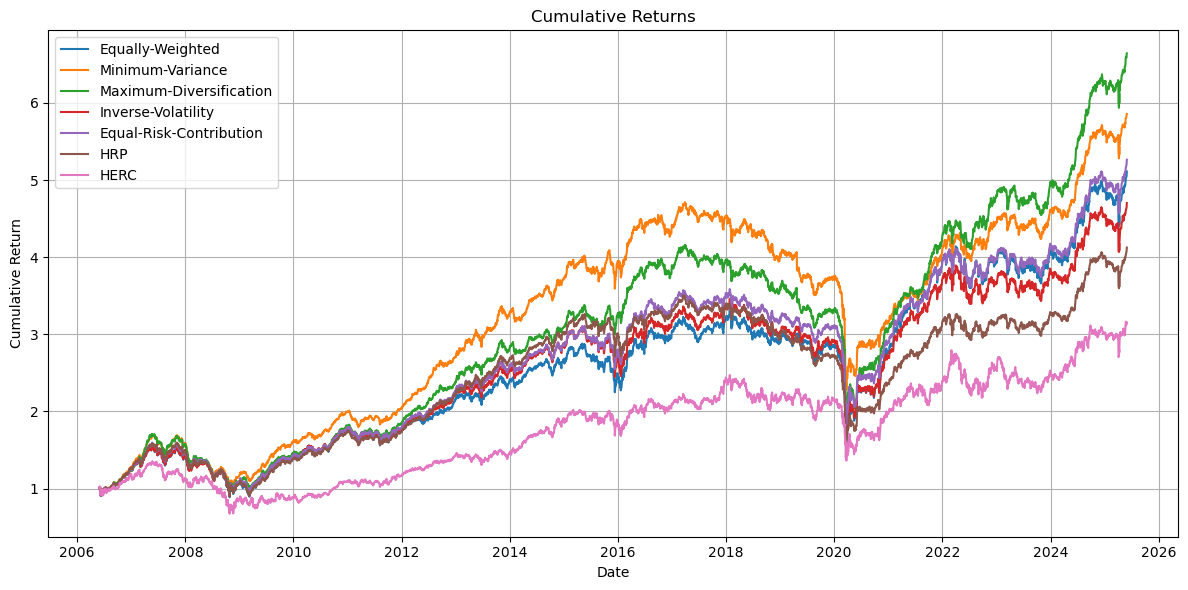

In [62]:
df_SP500_shrinked["Date"] = pd.to_datetime(df_SP500_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_shrinked = df_SP500_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sharpe_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [64]:
sharpe_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.182618          3.123449                 2.633520   
2007          0.910366          1.912135                 1.864129   
2008         -0.970536         -1.538262                -1.785173   
2009          1.687395          2.875205                 2.499221   
2010          1.839421          2.916966                 2.828114   
2011         -0.031028          0.349289                 0.267587   
2012          2.623623          4.650239                 4.001107   
2013          1.025757          2.413081                 2.065067   
2014          1.209907          1.948938                 1.317689   
2015         -0.465055          0.622978                 0.610836   
2016          1.466068          1.265982                 1.796767   
2017          0.829830          0.457839                 0.297779   
20

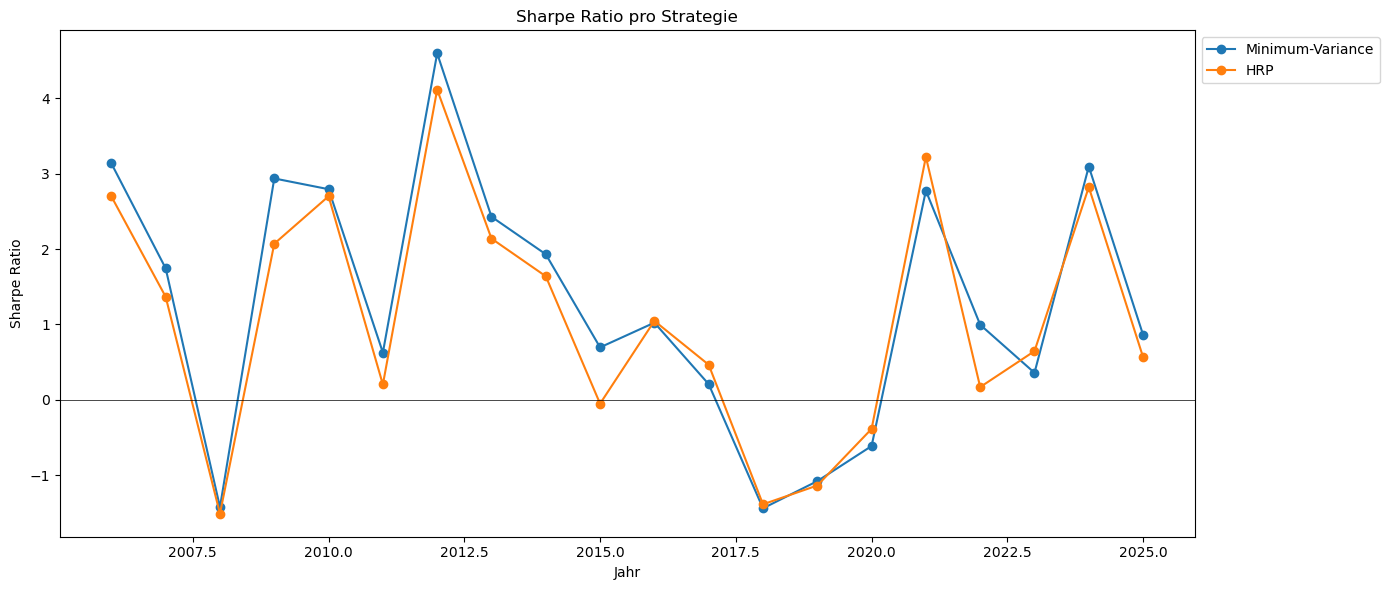

In [65]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [66]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
annual_sharpe_shrinked = df_SP500_shrinked.apply(sharpe_annual)

print(annual_sharpe_shrinked)

Equally-Weighted           0.657068
Minimum-Variance           0.899799
Maximum-Diversification    0.910555
Inverse-Volatility         0.638865
Equal-Risk-Contribution    0.735347
HRP                        0.670761
HERC                       0.416464
dtype: float64


In [67]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe_shrinked = df_SP500_shrinked.apply(sharpe_total)

print(gesamt_sharpe_shrinked)

Equally-Weighted           2.900351
Minimum-Variance           3.971786
Maximum-Diversification    4.019266
Inverse-Volatility         2.820004
Equal-Risk-Contribution    3.245882
HRP                        2.960796
HERC                       1.838307
dtype: float64


#### Sortino Ratio

In [68]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sortino_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          3.079217          4.640445                 3.814632   
2007          1.257997          2.664734                 2.674871   
2008         -1.298916         -1.977205                -2.272566   
2009          2.527104          4.681690                 3.970949   
2010          2.737512          4.403362                 4.340783   
2011         -0.041902          0.467453                 0.361171   
2012          3.967689          8.637812                 6.967008   
2013          1.397155          3.595733                 2.987954   
2014          1.781424          2.871045                 1.900318   
2015         -0.605926          0.853396                 0.853004   
2016          2.195466          1.830896                 2.743121   
2017          1.254059          0.640594                 0.419716   
20

In [69]:
#Annualisierte Sortino
annualized_sortino_shrinked = df_SP500_shrinked.apply(sortino_annual)
print(annualized_sortino_shrinked)

Equally-Weighted           0.912107
Minimum-Variance           1.214332
Maximum-Diversification    1.242181
Inverse-Volatility         0.883372
Equal-Risk-Contribution    1.009622
HRP                        0.903780
HERC                       0.585600
dtype: float64


In [70]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_shrinked = df_SP500_shrinked.apply(sortino_total)

print(gesamt_sortino_shrinked)

Equally-Weighted           4.026115
Minimum-Variance           5.360162
Maximum-Diversification    5.483089
Inverse-Volatility         3.899276
Equal-Risk-Contribution    4.456556
HRP                        3.989359
HERC                       2.584887
dtype: float64


In [71]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.111824         -0.092458                -0.103207   
2007         -0.160553         -0.148380                -0.156290   
2008         -0.376662         -0.376457                -0.398224   
2009         -0.197326         -0.103435                -0.118641   
2010         -0.075729         -0.048553                -0.044000   
2011         -0.125199         -0.107125                -0.106209   
2012         -0.040318         -0.029785                -0.031975   
2013         -0.074547         -0.072611                -0.061781   
2014         -0.080826         -0.053583                -0.058615   
2015         -0.218784         -0.121842                -0.112040   
2016         -0.083945         -0.062333                -0.064284   
2017         -0.101262         -0.075662                -0.085194   
20

In [72]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_total_shrinked = df_SP500_shrinked.apply(maximum_drawdown)

max_drawdown_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.504756
Minimum-Variance          -0.516921
Maximum-Diversification   -0.526626
Inverse-Volatility        -0.512488
Equal-Risk-Contribution   -0.490386
HRP                       -0.552463
HERC                      -0.503103
dtype: float64>

#### Calmar Ratio

In [73]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          4.127585          5.496742                 4.268131   
2007          0.758864          1.608797                 1.658983   
2008         -0.623430         -0.683095                -0.756165   
2009          1.614904          3.562308                 2.825702   
2010          3.003705          4.584228                 5.187228   
2011         -0.085008          0.214412                 0.170782   
2012          5.633631         10.478417                 8.576195   
2013          1.496645          2.845279                 2.962612   
2014          1.332254          2.416686                 1.544246   
2015         -0.313843          0.477862                 0.502987   
2016          2.569736          1.843524                 2.845311   
2017          0.623812          0.336483                 0.201926   
20

In [74]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_total_2_shrinked = df_SP500_shrinked.apply(calmar_ratio_total)

calmar_total_2_shrinked.info

<bound method Series.info of Equally-Weighted            8.143756
Minimum-Variance            9.393812
Maximum-Diversification    10.713588
Inverse-Volatility          7.222046
Equal-Risk-Contribution     8.693270
HRP                         5.655794
HERC                        4.279999
dtype: float64>

##### Value at Risk

In [75]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.020351         -0.009396                -0.011920   
2007         -0.014836         -0.011699                -0.014029   
2008         -0.026224         -0.022186                -0.023028   
2009         -0.018354         -0.010292                -0.010563   
2010         -0.011905         -0.007209                -0.007331   
2011         -0.012818         -0.008182                -0.008506   
2012         -0.008461         -0.004626                -0.005159   
2013         -0.012782         -0.007696                -0.008271   
2014         -0.008447         -0.006311                -0.006561   
2015         -0.014589         -0.007983                -0.008725   
2016         -0.013721         -0.009952                -0.009663   
2017         -0.007498         -0.005969                -0.005631   
20

In [76]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_total_shrinked = df_SP500_shrinked.apply(value_at_risk_func)

var_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.012955
Minimum-Variance          -0.009217
Maximum-Diversification   -0.009744
Inverse-Volatility        -0.012875
Equal-Risk-Contribution   -0.011510
HRP                       -0.010539
HERC                      -0.017525
dtype: float64>

In [77]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_shrinked = monthly_returns_shrinked.apply(value_at_risk_func)

monthly_var_shrinked.info

<bound method Series.info of Equally-Weighted          -0.042644
Minimum-Variance          -0.039097
Maximum-Diversification   -0.041033
Inverse-Volatility        -0.043238
Equal-Risk-Contribution   -0.041036
HRP                       -0.043923
HERC                      -0.066241
dtype: float64>

#### Expected Shortfall

In [78]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.028949         -0.020711                -0.022637   
2007         -0.021117         -0.018637                -0.019555   
2008         -0.035400         -0.029358                -0.030957   
2009         -0.022420         -0.013398                -0.014935   
2010         -0.015709         -0.009962                -0.010103   
2011         -0.017125         -0.010878                -0.011807   
2012         -0.011236         -0.006649                -0.007224   
2013         -0.016932         -0.011163                -0.012173   
2014         -0.012410         -0.008958                -0.009340   
2015         -0.020844         -0.014683                -0.014232   
2016         -0.019406         -0.013059                -0.013308   
2017         -0.009776         -0.008644                -0.008997   
20

In [79]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_total_shrinked = df_SP500_shrinked.apply(expected_shortfall)

es_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.021511
Minimum-Variance          -0.016164
Maximum-Diversification   -0.017071
Inverse-Volatility        -0.021014
Equal-Risk-Contribution   -0.019238
HRP                       -0.018337
HERC                      -0.026811
dtype: float64>

In [80]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_shrinked  = monthly_returns_shrinked.apply(expected_shortfall)

monthly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.092823
Minimum-Variance          -0.084675
Maximum-Diversification   -0.091724
Inverse-Volatility        -0.091474
Equal-Risk-Contribution   -0.090138
HRP                       -0.093358
HERC                      -0.101896
dtype: float64>

In [81]:
yearly_returns_shrinked = df_SP500_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_shrinked  = yearly_returns_shrinked.apply(expected_shortfall)

yearly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.240490
Minimum-Variance          -0.263265
Maximum-Diversification   -0.308044
Inverse-Volatility        -0.233497
Equal-Risk-Contribution   -0.253805
HRP                       -0.284852
HERC                      -0.219176
dtype: float64>

In [82]:
#Zusammenfassung der Metriken
Zusammenfassung_shrinked = pd.concat([annualized_sharpe, annualized_sortino_shrinked, max_drawdown_total_shrinked, calmar_total_2_shrinked, monthly_var_shrinked, monthly_es_shrinked], axis=1)
Zusammenfassung_shrinked.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_shrinked)

                           Sharpe   Sortino  Max Drawdown     Calmar  \
Equally-Weighted         0.657068  0.912107     -0.504756   8.143756   
Minimum-Variance         0.853628  1.214332     -0.516921   9.393812   
Maximum-Diversification  0.912966  1.242181     -0.526626  10.713588   
Inverse-Volatility       0.632077  0.883372     -0.512488   7.222046   
Equal-Risk-Contribution  0.748109  1.009622     -0.490386   8.693270   
HRP                      0.688922  0.903780     -0.552463   5.655794   
HERC                     0.470725  0.585600     -0.503103   4.279999   

                              Var        ES  
Equally-Weighted        -0.042644 -0.092823  
Minimum-Variance        -0.039097 -0.084675  
Maximum-Diversification -0.041033 -0.091724  
Inverse-Volatility      -0.043238 -0.091474  
Equal-Risk-Contribution -0.041036 -0.090138  
HRP                     -0.043923 -0.093358  
HERC                    -0.066241 -0.101896  


## 2-Jahre Trainingsfenster S&P500

In [83]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre = pd.read_csv(
    'returnsJSE_neu_2jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [84]:
df_SP500_2jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2007-06-01          0.000000          0.000000                 0.000000   
1     2007-06-04         -0.001916          0.001767                 0.001083   
2     2007-06-05         -0.000075          0.005194                 0.003117   
3     2007-06-06         -0.006310         -0.000717                -0.003486   
4     2007-06-07          0.001109         -0.001658                 0.000423   
...          ...               ...               ...                      ...   
4647  2025-05-26          0.005171          0.003546                 0.005399   
4648  2025-05-27         -0.000215          0.000589                -0.002193   
4649  2025-05-28          0.000539          0.003205                 0.004150   
4650  2025-05-29          0.008810          0.000637                 0.001794   
4651  2025-05-30          0.003425          0.004305                 0.004464

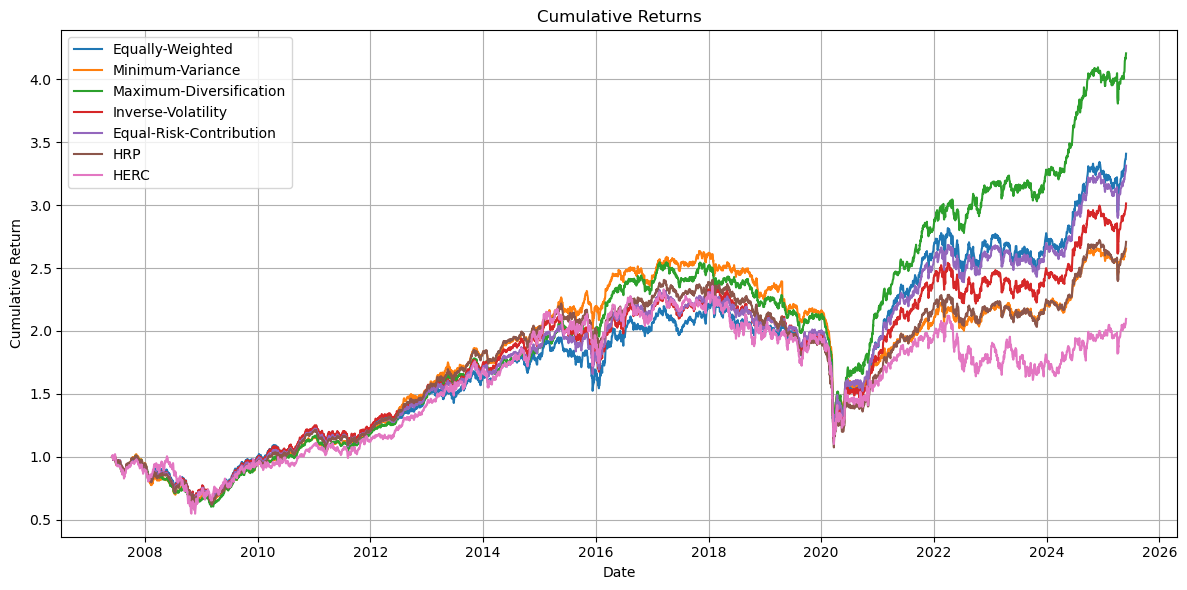

In [85]:
df_SP500_2jahre["Date"] = pd.to_datetime(df_SP500_2jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre = df_SP500_2jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sharpe_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.766450         -0.659736                -0.734556   
2008         -0.769364         -1.709406                -1.844670   
2009          1.794359          2.960852                 2.881985   
2010          1.664275          2.198917                 1.975685   
2011         -0.086960          0.544105                 0.270174   
2012          2.509539          4.024494                 3.419257   
2013          0.941638          2.238310                 1.911008   
2014          1.095084          1.612378                 1.187194   
2015         -0.439779          0.766235                 0.757964   
2016          1.425379          1.194716                 1.734556   
2017          0.889854          1.070612                 0.659574   
2018         -0.842847         -1.447589                -1.170161   
20

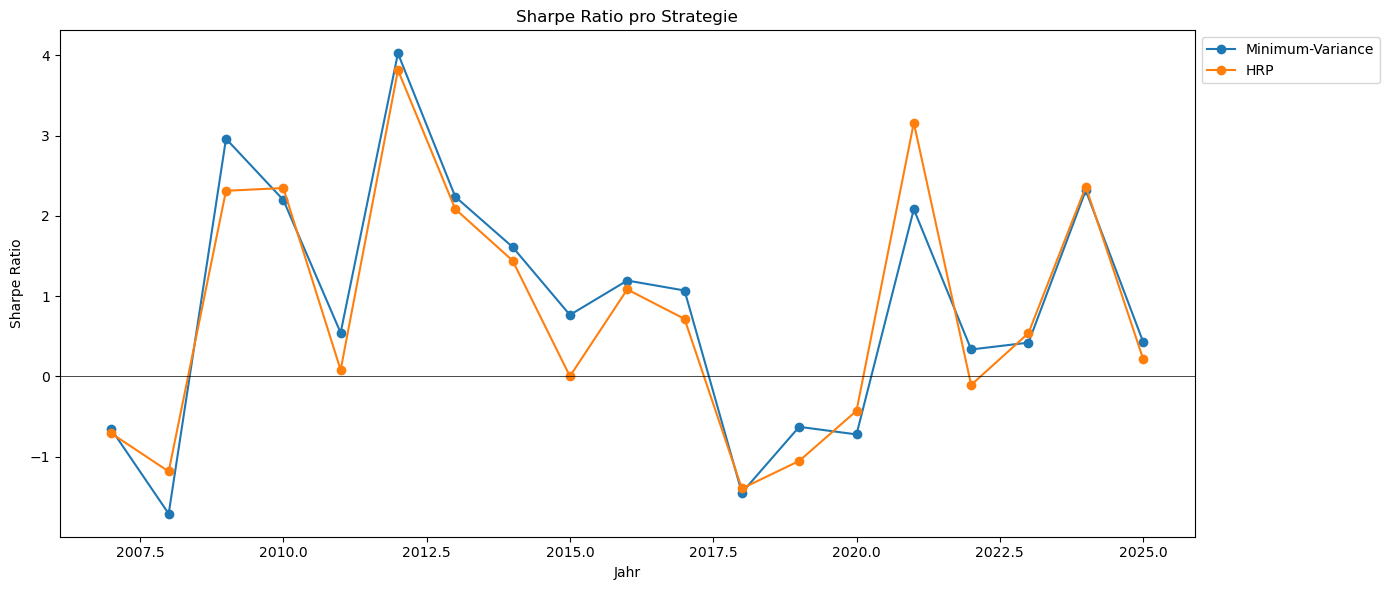

In [87]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre.columns
years = sharpe_jahresweise_2jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

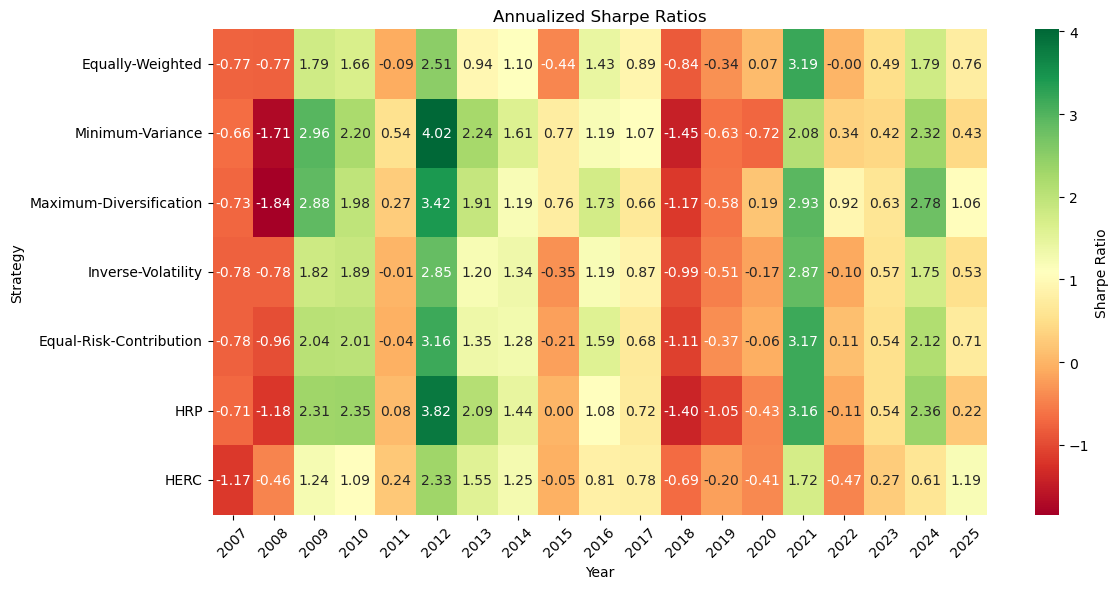

In [88]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise_2jahre.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualized Sharpe Ratios")
plt.xlabel("Year")
plt.ylabel("Strategy")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [89]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_total_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4652)  # 252 Handelstage

gesamt_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_total_2jahre)

print(gesamt_sharpe_2jahre)

Equally-Weighted           2.301068
Minimum-Variance           2.328776
Maximum-Diversification    3.145327
Inverse-Volatility         2.132411
Equal-Risk-Contribution    2.466026
HRP                        2.203241
HERC                       1.342107
dtype: float64


In [90]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

annualized_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_annual_2jahre)

print(annualized_sharpe_2jahre)

Equally-Weighted           0.535562
Minimum-Variance           0.542011
Maximum-Diversification    0.732059
Inverse-Volatility         0.496308
Equal-Risk-Contribution    0.573955
HRP                        0.512793
HERC                       0.312369
dtype: float64


In [91]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sortino_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -1.020709         -0.817502                -0.932074   
2008         -1.042889         -2.160353                -2.282521   
2009          2.709818          4.715980                 4.653064   
2010          2.452206          3.226131                 2.873751   
2011         -0.116886          0.724428                 0.358913   
2012          3.776152          7.337618                 6.073544   
2013          1.277677          3.286532                 2.765977   
2014          1.621649          2.388508                 1.710709   
2015         -0.577660          1.021221                 1.049519   
2016          2.160234          1.769396                 2.662578   
2017          1.356261          1.622297                 0.981028   
2018         -1.158123         -1.832696                -1.510585   
20

In [92]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4529)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre = df_SP500_2jahre.apply(sortino_total_2jahre)

print(gesamt_sortino_2jahre)

Equally-Weighted           3.153496
Minimum-Variance           3.006112
Maximum-Diversification    4.192229
Inverse-Volatility         2.907621
Equal-Risk-Contribution    3.329463
HRP                        2.913897
HERC                       1.851796
dtype: float64


In [93]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino_2jahre = df_SP500_2jahre.apply(sortino_annual_2jahre)

print(annualized_sortino_2jahre)

Equally-Weighted           0.743860
Minimum-Variance           0.709095
Maximum-Diversification    0.988881
Inverse-Volatility         0.685862
Equal-Risk-Contribution    0.785368
HRP                        0.687343
HERC                       0.436810
dtype: float64


In [94]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.140902         -0.139970                -0.146619   
2008         -0.346720         -0.371440                -0.376538   
2009         -0.188376         -0.101621                -0.122362   
2010         -0.079356         -0.048620                -0.060432   
2011         -0.130200         -0.110083                -0.112346   
2012         -0.039916         -0.028050                -0.025333   
2013         -0.076179         -0.080325                -0.062654   
2014         -0.080151         -0.056189                -0.059085   
2015         -0.217897         -0.128256                -0.127457   
2016         -0.082594         -0.062131                -0.060667   
2017         -0.104501         -0.042985                -0.078719   
2018         -0.142043         -0.140213                -0.131536   
20

In [95]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_total_2jahre = df_SP500_2jahre.apply(maximum_drawdown)

max_drawdown_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.511636
Minimum-Variance          -0.525557
Maximum-Diversification   -0.509491
Inverse-Volatility        -0.530110
Equal-Risk-Contribution   -0.500715
HRP                       -0.553020
HERC                      -0.532494
dtype: float64>

In [96]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.804037         -0.591581                -0.631221   
2008         -0.564748         -0.728063                -0.780962   
2009          1.808673          3.723528                 3.611514   
2010          2.738478          4.064848                 3.341651   
2011         -0.136742          0.354540                 0.171625   
2012          5.464563          9.480236                 9.290375   
2013          1.348908          2.374583                 2.630969   
2014          1.230145          1.947412                 1.384275   
2015         -0.305451          0.593240                 0.609491   
2016          2.633718          1.710972                 2.926851   
2017          0.685402          1.613912                 0.587928   
2018         -0.670534         -0.835524                -0.781022   
20

In [97]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_total_2_2jahre = df_SP500_2jahre.apply(calmar_ratio_total)

calmar_total_2_2jahre.info

<bound method Series.info of Equally-Weighted           4.704592
Minimum-Variance           3.147176
Maximum-Diversification    6.288900
Inverse-Volatility         3.796223
Equal-Risk-Contribution    4.617476
HRP                        3.088042
HERC                       2.058230
dtype: float64>

In [98]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.017227         -0.011713                -0.011792   
2008         -0.026163         -0.023507                -0.022026   
2009         -0.018850         -0.010845                -0.011934   
2010         -0.012077         -0.008060                -0.008533   
2011         -0.012953         -0.008188                -0.008698   
2012         -0.008220         -0.005230                -0.005572   
2013         -0.012780         -0.007125                -0.008211   
2014         -0.008918         -0.006929                -0.006629   
2015         -0.014699         -0.009255                -0.010267   
2016         -0.014169         -0.008382                -0.008685   
2017         -0.008098         -0.006230                -0.007401   
2018         -0.010881         -0.009287                -0.009513   
20

In [99]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_total_2jahre = df_SP500_2jahre.apply(value_at_risk_func)

var_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.013276
Minimum-Variance          -0.009233
Maximum-Diversification   -0.009839
Inverse-Volatility        -0.012780
Equal-Risk-Contribution   -0.011311
HRP                       -0.010521
HERC                      -0.017431
dtype: float64>

In [100]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre = monthly_returns_2jahre.apply(value_at_risk_func)

monthly_var_2jahre.info

<bound method Series.info of Equally-Weighted          -0.045862
Minimum-Variance          -0.047339
Maximum-Diversification   -0.045745
Inverse-Volatility        -0.045870
Equal-Risk-Contribution   -0.045526
HRP                       -0.046277
HERC                      -0.060519
dtype: float64>

In [101]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.021059         -0.020479                -0.019864   
2008         -0.034756         -0.029624                -0.030277   
2009         -0.021976         -0.013634                -0.017377   
2010         -0.016790         -0.011884                -0.013004   
2011         -0.017740         -0.012002                -0.013044   
2012         -0.011408         -0.006529                -0.006902   
2013         -0.017134         -0.011144                -0.011602   
2014         -0.012432         -0.008971                -0.009423   
2015         -0.020716         -0.015692                -0.015684   
2016         -0.019551         -0.012317                -0.013002   
2017         -0.010292         -0.008120                -0.009312   
2018         -0.014288         -0.012871                -0.013189   
20

In [102]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_total_2jahre = df_SP500_2jahre.apply(expected_shortfall)

es_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.021217
Minimum-Variance          -0.016426
Maximum-Diversification   -0.017330
Inverse-Volatility        -0.020802
Equal-Risk-Contribution   -0.019054
HRP                       -0.018153
HERC                      -0.026597
dtype: float64>

In [103]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre  = monthly_returns_2jahre.apply(expected_shortfall)

monthly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.094179
Minimum-Variance          -0.092043
Maximum-Diversification   -0.087634
Inverse-Volatility        -0.094068
Equal-Risk-Contribution   -0.091522
HRP                       -0.095725
HERC                      -0.109783
dtype: float64>

In [104]:
yearly_returns_2jahre = df_SP500_2jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre  = yearly_returns_2jahre.apply(expected_shortfall)

yearly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.200663
Minimum-Variance          -0.276794
Maximum-Diversification   -0.300857
Inverse-Volatility        -0.196267
Equal-Risk-Contribution   -0.216021
HRP                       -0.238330
HERC                      -0.186228
dtype: float64>

In [105]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre = pd.concat([annualized_sharpe_2jahre, annualized_sortino_2jahre, max_drawdown_total_2jahre, calmar_total_2_2jahre, monthly_var_2jahre, monthly_es_2jahre], axis=1)
Zusammenfassung_2jahre.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.535562  0.743860     -0.511636  4.704592 -0.045862   
Minimum-Variance         0.542011  0.709095     -0.525557  3.147176 -0.047339   
Maximum-Diversification  0.732059  0.988881     -0.509491  6.288900 -0.045745   
Inverse-Volatility       0.496308  0.685862     -0.530110  3.796223 -0.045870   
Equal-Risk-Contribution  0.573955  0.785368     -0.500715  4.617476 -0.045526   
HRP                      0.512793  0.687343     -0.553020  3.088042 -0.046277   
HERC                     0.312369  0.436810     -0.532494  2.058230 -0.060519   

                               ES  
Equally-Weighted        -0.094179  
Minimum-Variance        -0.092043  
Maximum-Diversification -0.087634  
Inverse-Volatility      -0.094068  
Equal-Risk-Contribution -0.091522  
HRP                     -0.095725  
HERC                    -0.109783  


## S&P 500 2Jahre Shrinked

In [106]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre_shrinked = pd.read_csv(
    'returnsJSEshrinked_neu_2jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [107]:
df_SP500_2jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2007-06-01          0.000000          0.000000                 0.000000   
1     2007-06-04         -0.001916          0.001503                 0.001113   
2     2007-06-05         -0.000075          0.005232                 0.003280   
3     2007-06-06         -0.006310         -0.000551                -0.003184   
4     2007-06-07          0.001109         -0.001603                 0.000191   
...          ...               ...               ...                      ...   
4647  2025-05-26          0.005171          0.003896                 0.005644   
4648  2025-05-27         -0.000215          0.000966                -0.001851   
4649  2025-05-28          0.000539          0.003251                 0.003715   
4650  2025-05-29          0.008810          0.001312                 0.002390   
4651  2025-05-30          0.003425          0.004429                 0.004608

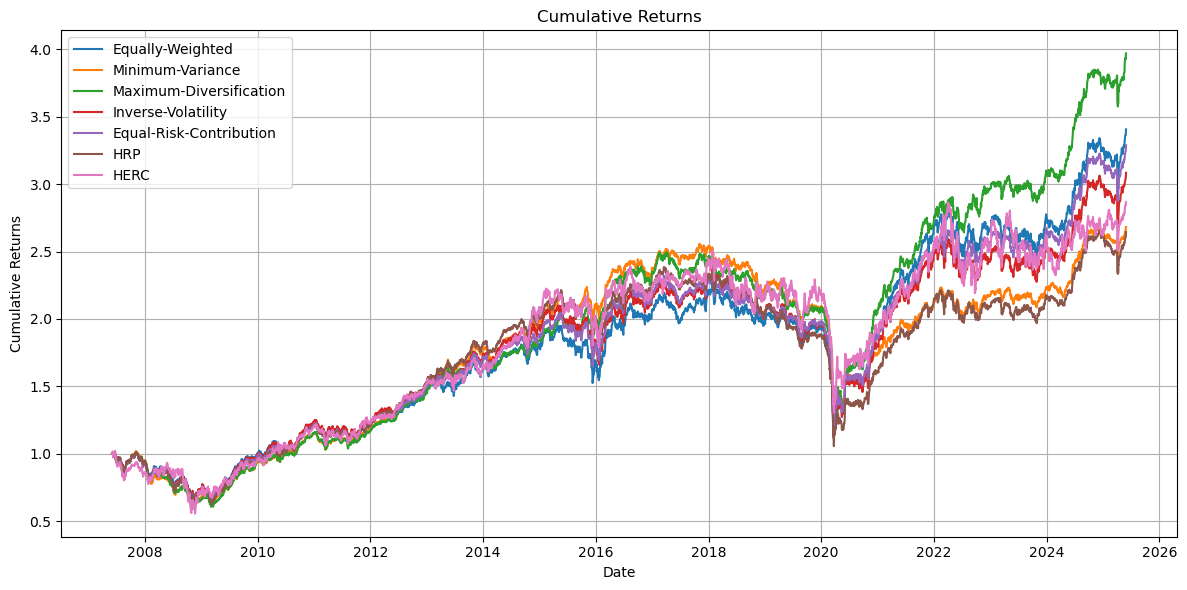

In [108]:
df_SP500_2jahre_shrinked["Date"] = pd.to_datetime(df_SP500_2jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre_shrinked = df_SP500_2jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [109]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sharpe_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.766450         -0.664164                -0.743515   
2008         -0.769364         -1.736525                -1.824411   
2009          1.794359          2.955911                 2.878506   
2010          1.664275          2.278179                 2.014629   
2011         -0.086960          0.390854                 0.208132   
2012          2.509539          3.941774                 3.441031   
2013          0.941638          2.213234                 1.898804   
2014          1.095084          1.672100                 1.225643   
2015         -0.439779          0.642154                 0.742085   
2016          1.425379          1.343669                 1.738592   
2017          0.889854          1.006548                 0.638130   
2018         -0.842847         -1.456160                -1.196377   
20

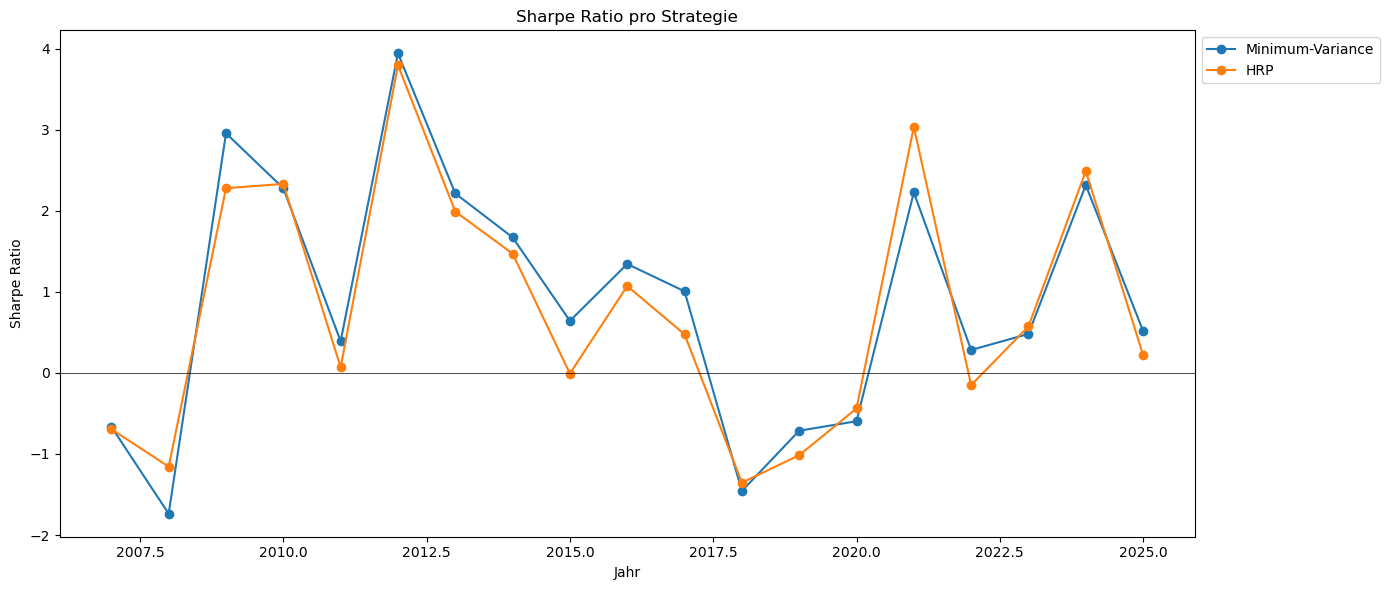

In [110]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre_shrinked.columns
years = sharpe_jahresweise_2jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [111]:
gesamt_sharpe_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sharpe_annual_2jahre)

print(gesamt_sharpe_2jahre_shrinked)

Equally-Weighted           0.535562
Minimum-Variance           0.550870
Maximum-Diversification    0.714796
Inverse-Volatility         0.504631
Equal-Risk-Contribution    0.569824
HRP                        0.500127
HERC                       0.403736
dtype: float64


In [112]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sortino_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -1.020709         -0.821544                -0.940530   
2008         -1.042889         -2.194875                -2.266651   
2009          2.709818          4.705736                 4.631895   
2010          2.452206          3.345057                 2.928895   
2011         -0.116886          0.515191                 0.275381   
2012          3.776152          7.146399                 6.095044   
2013          1.277677          3.243414                 2.738662   
2014          1.621649          2.476374                 1.773223   
2015         -0.577660          0.852944                 1.021492   
2016          2.160234          1.994665                 2.666723   
2017          1.356261          1.526181                 0.949709   
2018         -1.158123         -1.847288                -1.545447   
20

In [113]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sortino_annual_2jahre)

print(gesamt_sortino_2jahre_shrinked)

Equally-Weighted           0.743860
Minimum-Variance           0.724670
Maximum-Diversification    0.962688
Inverse-Volatility         0.697997
Equal-Risk-Contribution    0.780479
HRP                        0.671018
HERC                       0.568715
dtype: float64


In [114]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.140902         -0.139301                -0.147148   
2008         -0.346720         -0.376647                -0.379640   
2009         -0.188376         -0.101840                -0.121219   
2010         -0.079356         -0.048822                -0.059246   
2011         -0.130200         -0.109927                -0.111968   
2012         -0.039916         -0.027534                -0.025428   
2013         -0.076179         -0.078633                -0.063735   
2014         -0.080151         -0.055677                -0.057751   
2015         -0.217897         -0.132861                -0.127453   
2016         -0.082594         -0.060138                -0.059105   
2017         -0.104501         -0.046187                -0.077979   
2018         -0.142043         -0.140903                -0.131165   
20

In [115]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.511636
Minimum-Variance          -0.519314
Maximum-Diversification   -0.504950
Inverse-Volatility        -0.527299
Equal-Risk-Contribution   -0.503344
HRP                       -0.557013
HERC                      -0.480783
dtype: float64>

In [116]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.804037         -0.594788                -0.630704   
2008         -0.564748         -0.728694                -0.772642   
2009          1.808673          3.673758                 3.576525   
2010          2.738478          4.193059                 3.386180   
2011         -0.136742          0.246602                 0.123890   
2012          5.464563          9.170600                 9.072550   
2013          1.348908          2.380193                 2.549523   
2014          1.230145          2.015803                 1.443244   
2015         -0.305451          0.473064                 0.590375   
2016          2.633718          2.016965                 2.985418   
2017          0.685402          1.393877                 0.563782   
2018         -0.670534         -0.834997                -0.787056   
20

In [117]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_total_2_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted           4.704592
Minimum-Variance           3.240511
Maximum-Diversification    5.884132
Inverse-Volatility         3.953348
Equal-Risk-Contribution    4.547974
HRP                        2.952167
HERC                       3.883664
dtype: float64>

In [118]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.017227         -0.011975                -0.011826   
2008         -0.026163         -0.023477                -0.022260   
2009         -0.018850         -0.010742                -0.011338   
2010         -0.012077         -0.007896                -0.008826   
2011         -0.012953         -0.008103                -0.008793   
2012         -0.008220         -0.005365                -0.005533   
2013         -0.012780         -0.007502                -0.008402   
2014         -0.008918         -0.006870                -0.006598   
2015         -0.014699         -0.009283                -0.009933   
2016         -0.014169         -0.008526                -0.008464   
2017         -0.008098         -0.006355                -0.007301   
2018         -0.010881         -0.009525                -0.009388   
20

In [119]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(value_at_risk_func)

var_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.013276
Minimum-Variance          -0.009201
Maximum-Diversification   -0.009655
Inverse-Volatility        -0.012830
Equal-Risk-Contribution   -0.011333
HRP                       -0.010743
HERC                      -0.017432
dtype: float64>

In [120]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre_shrinked = monthly_returns_2jahre_shrinked.apply(value_at_risk_func)

monthly_var_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.045862
Minimum-Variance          -0.047880
Maximum-Diversification   -0.046078
Inverse-Volatility        -0.045773
Equal-Risk-Contribution   -0.045539
HRP                       -0.045974
HERC                      -0.055373
dtype: float64>

In [121]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2007         -0.021059         -0.020388                -0.019838   
2008         -0.034756         -0.029580                -0.030413   
2009         -0.021976         -0.013503                -0.017063   
2010         -0.016790         -0.011785                -0.012672   
2011         -0.017740         -0.012124                -0.012988   
2012         -0.011408         -0.006348                -0.006780   
2013         -0.017134         -0.011122                -0.011669   
2014         -0.012432         -0.008878                -0.009236   
2015         -0.020716         -0.015807                -0.015674   
2016         -0.019551         -0.012478                -0.012999   
2017         -0.010292         -0.008126                -0.009168   
2018         -0.014288         -0.012805                -0.013013   
20

In [122]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(expected_shortfall)

es_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.021217
Minimum-Variance          -0.016267
Maximum-Diversification   -0.017109
Inverse-Volatility        -0.020839
Equal-Risk-Contribution   -0.019090
HRP                       -0.018257
HERC                      -0.026907
dtype: float64>

In [123]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre_shrinked  = monthly_returns_2jahre_shrinked.apply(expected_shortfall)

monthly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.094179
Minimum-Variance          -0.091267
Maximum-Diversification   -0.088153
Inverse-Volatility        -0.093953
Equal-Risk-Contribution   -0.091487
HRP                       -0.095583
HERC                      -0.102435
dtype: float64>

In [124]:
yearly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre_shrinked  = yearly_returns_2jahre_shrinked.apply(expected_shortfall)

yearly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.200663
Minimum-Variance          -0.280898
Maximum-Diversification   -0.300108
Inverse-Volatility        -0.197103
Equal-Risk-Contribution   -0.213799
HRP                       -0.235542
HERC                      -0.152714
dtype: float64>

In [125]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre_shrinked = pd.concat([gesamt_sharpe_2jahre_shrinked, gesamt_sortino_2jahre_shrinked, max_drawdown_total_2jahre_shrinked, calmar_total_2_2jahre_shrinked, monthly_var_2jahre_shrinked, monthly_es_2jahre_shrinked], axis=1)
Zusammenfassung_2jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.535562  0.743860     -0.511636  4.704592 -0.045862   
Minimum-Variance         0.550870  0.724670     -0.519314  3.240511 -0.047880   
Maximum-Diversification  0.714796  0.962688     -0.504950  5.884132 -0.046078   
Inverse-Volatility       0.504631  0.697997     -0.527299  3.953348 -0.045773   
Equal-Risk-Contribution  0.569824  0.780479     -0.503344  4.547974 -0.045539   
HRP                      0.500127  0.671018     -0.557013  2.952167 -0.045974   
HERC                     0.403736  0.568715     -0.480783  3.883664 -0.055373   

                               ES  
Equally-Weighted        -0.094179  
Minimum-Variance        -0.091267  
Maximum-Diversification -0.088153  
Inverse-Volatility      -0.093953  
Equal-Risk-Contribution -0.091487  
HRP                     -0.095583  
HERC                    -0.102435  


## S&P500 3 Jahre

In [126]:
#Bearbeitete SP500-Daten (Gesamtbestand, 3 Jahre)

df_SP500_3jahre = pd.read_csv(
    'returnsJSE_neu_3jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [127]:
df_SP500_3jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2008-06-02         -0.006116         -0.004265                -0.005636   
1     2008-06-03         -0.003995         -0.007553                -0.005950   
2     2008-06-04         -0.005819         -0.009142                -0.014172   
3     2008-06-05          0.013402          0.005178                 0.005019   
4     2008-06-06         -0.000502          0.006984                 0.006826   
...          ...               ...               ...                      ...   
4389  2025-05-26          0.005216          0.004204                 0.007388   
4390  2025-05-27         -0.000361          0.000263                -0.001381   
4391  2025-05-28          0.000909          0.004564                 0.006221   
4392  2025-05-29          0.008972          0.004289                 0.003588   
4393  2025-05-30          0.003329          0.005229                 0.004024

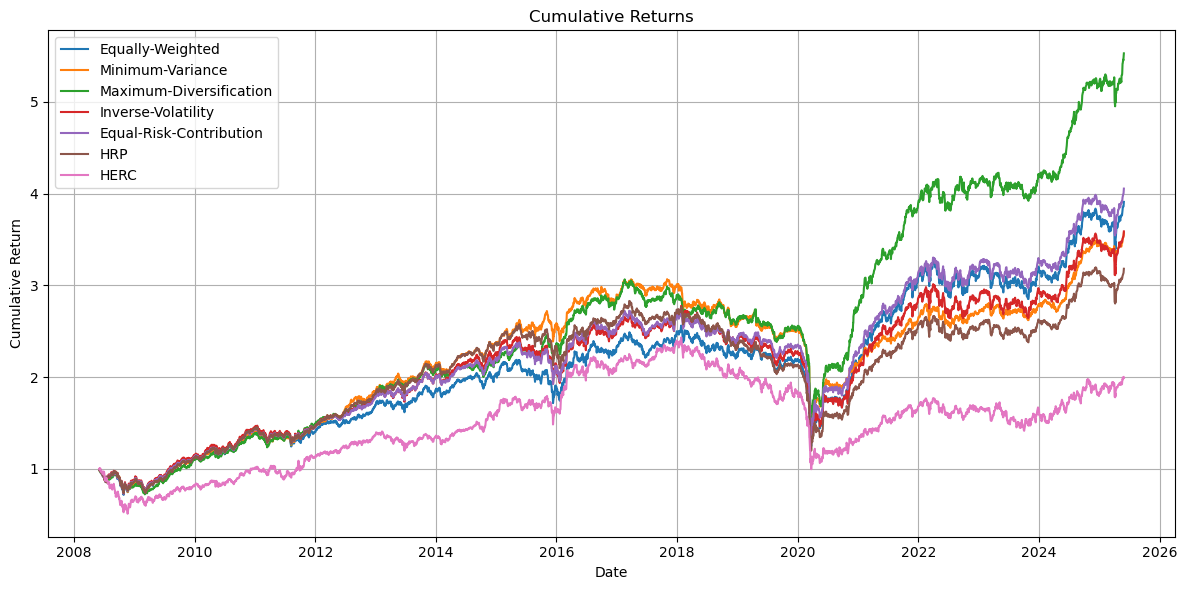

In [128]:
df_SP500_3jahre["Date"] = pd.to_datetime(df_SP500_3jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_3jahre = df_SP500_3jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_3jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [129]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
sharpe_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.662728         -1.411685                -1.657145   
2009          1.634533          2.863251                 2.516625   
2010          1.838356          2.606031                 2.403027   
2011         -0.065650          0.440441                 0.738321   
2012          2.282271          3.539723                 2.811868   
2013          0.887819          1.884926                 1.758017   
2014          0.983096          1.521904                 0.642621   
2015         -0.441398          0.871313                 0.859535   
2016          1.455534          1.225208                 1.901226   
2017          0.830074          0.585159                 0.141624   
2018         -0.791715         -1.442804                -0.902506   
2019         -0.354253         -0.316337                -0.326182   
20

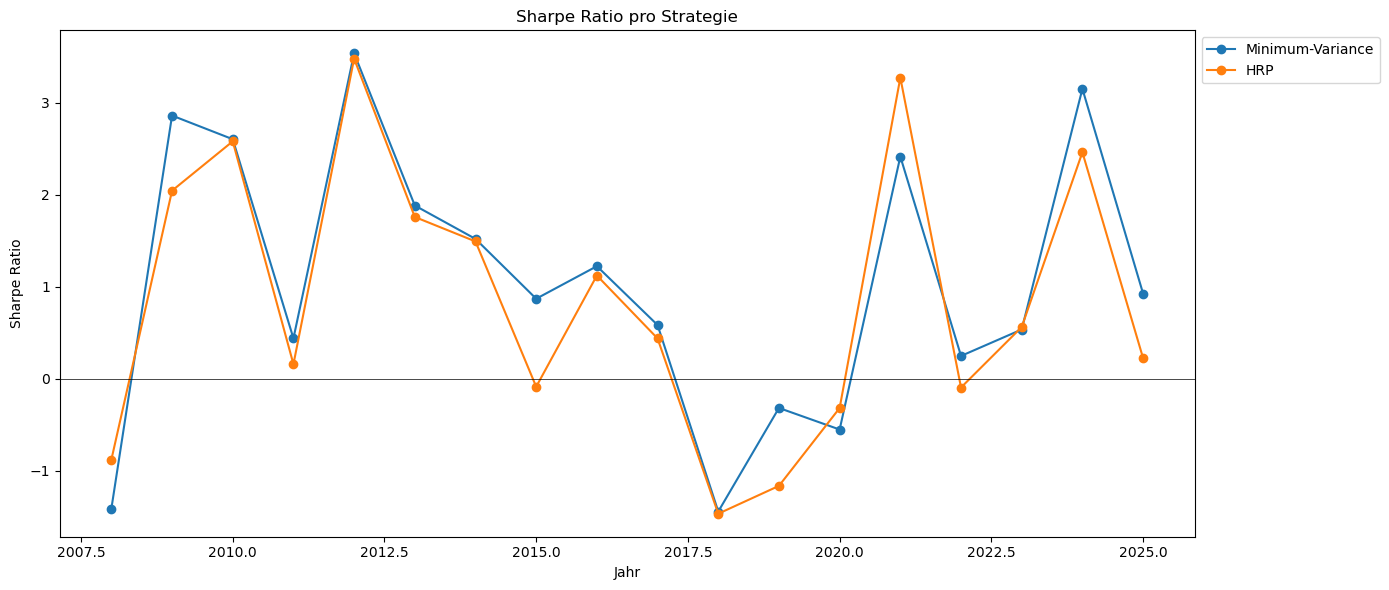

In [130]:
#Plotten der SR
strategien = sharpe_jahresweise_3jahre.columns
years = sharpe_jahresweise_3jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_3jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_3jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [131]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_total_3jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(4394)  # 252 Handelstage

gesamt_sharpe_3jahre = df_SP500_3jahre.apply(sharpe_total_3jahre)

print(gesamt_sharpe_3jahre)

Equally-Weighted           2.584823
Minimum-Variance           3.082257
Maximum-Diversification    3.864688
Inverse-Volatility         2.468896
Equal-Risk-Contribution    2.902149
HRP                        2.556855
HERC                       1.308352
dtype: float64


In [132]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_3jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

annualized_sharpe_3jahre = df_SP500_3jahre.apply(sharpe_annual_3jahre)

print(annualized_sharpe_3jahre)

Equally-Weighted           0.619015
Minimum-Variance           0.738141
Maximum-Diversification    0.925518
Inverse-Volatility         0.591253
Equal-Risk-Contribution    0.695008
HRP                        0.612317
HERC                       0.313325
dtype: float64


In [133]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
sortino_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.915300         -1.806339                -2.065453   
2009          2.469001          4.579403                 3.969054   
2010          2.748991          3.899162                 3.603890   
2011         -0.088524          0.598703                 1.012946   
2012          3.401434          6.129080                 4.756616   
2013          1.203144          2.722390                 2.507261   
2014          1.450084          2.280804                 0.921322   
2015         -0.580759          1.151283                 1.167549   
2016          2.208436          1.765050                 2.948068   
2017          1.248173          0.846742                 0.198424   
2018         -1.097885         -1.824733                -1.191218   
2019         -0.488597         -0.381724                -0.409618   
20

In [134]:
#Funktion für annualisierten Sharpe Ratio
def sortino_total_3jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(4277)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_3jahre = df_SP500_3jahre.apply(sortino_total_3jahre)

print(gesamt_sortino_3jahre)

Equally-Weighted           3.563555
Minimum-Variance           4.033426
Maximum-Diversification    5.177085
Inverse-Volatility         3.390483
Equal-Risk-Contribution    3.953019
HRP                        3.424379
HERC                       1.802700
dtype: float64


In [135]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_3jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
annualized_sortino_3jahre = df_SP500_3jahre.apply(sortino_annual_3jahre)

print(annualized_sortino_3jahre)

Equally-Weighted           0.864996
Minimum-Variance           0.979050
Maximum-Diversification    1.256655
Inverse-Volatility         0.822985
Equal-Risk-Contribution    0.959532
HRP                        0.831213
HERC                       0.437577
dtype: float64


In [136]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
max_drawdown_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.280614         -0.249368                -0.241861   
2009         -0.192024         -0.106626                -0.132773   
2010         -0.075113         -0.043267                -0.053716   
2011         -0.137377         -0.125680                -0.113943   
2012         -0.043529         -0.035341                -0.030597   
2013         -0.076174         -0.085037                -0.063896   
2014         -0.083664         -0.052803                -0.065766   
2015         -0.215446         -0.121809                -0.117304   
2016         -0.079158         -0.075751                -0.054148   
2017         -0.110641         -0.057728                -0.098302   
2018         -0.140946         -0.155515                -0.114382   
2019         -0.125438         -0.119553                -0.129737   
20

In [137]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
max_drawdown_total_3jahre = df_SP500_3jahre.apply(maximum_drawdown)

max_drawdown_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.513253
Minimum-Variance          -0.511318
Maximum-Diversification   -0.495603
Inverse-Volatility        -0.538462
Equal-Risk-Contribution   -0.497740
HRP                       -0.576522
HERC                      -0.590180
dtype: float64>

In [138]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
calmar_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.725047         -1.020938                -1.188513   
2009          1.569383          3.297448                 2.651470   
2010          3.199084          5.341196                 4.507475   
2011         -0.119112          0.298628                 0.614273   
2012          4.566819          6.842862                 6.465940   
2013          1.267918          1.903282                 2.345061   
2014          1.072921          1.965719                 0.665871   
2015         -0.312279          0.700159                 0.753877   
2016          2.831036          1.533005                 3.768980   
2017          0.621960          0.632808                 0.077242   
2018         -0.652664         -0.853908                -0.758913   
2019         -0.281249         -0.276039                -0.267808   
20

In [139]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
calmar_total_2_3jahre = df_SP500_3jahre.apply(calmar_ratio_total)

calmar_total_2_3jahre.info

<bound method Series.info of Equally-Weighted           5.671651
Minimum-Variance           5.037672
Maximum-Diversification    9.140064
Inverse-Volatility         4.808968
Equal-Risk-Contribution    6.139108
HRP                        3.785119
HERC                       1.688941
dtype: float64>

In [140]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
var_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.026270         -0.024341                -0.021739   
2009         -0.017773         -0.010377                -0.012264   
2010         -0.011956         -0.007623                -0.008583   
2011         -0.013835         -0.010236                -0.010003   
2012         -0.008507         -0.004902                -0.006250   
2013         -0.013027         -0.008386                -0.007781   
2014         -0.008899         -0.006466                -0.007293   
2015         -0.014694         -0.009464                -0.010125   
2016         -0.013663         -0.009721                -0.009767   
2017         -0.008677         -0.006640                -0.007891   
2018         -0.011061         -0.010114                -0.010312   
2019         -0.009106         -0.007674                -0.008579   
20

In [141]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
var_total_3jahre = df_SP500_3jahre.apply(value_at_risk_func)

var_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.013287
Minimum-Variance          -0.009125
Maximum-Diversification   -0.009765
Inverse-Volatility        -0.012812
Equal-Risk-Contribution   -0.011453
HRP                       -0.010565
HERC                      -0.016640
dtype: float64>

In [142]:
monthly_returns_3jahre = df_SP500_3jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_3jahre = monthly_returns_3jahre.apply(value_at_risk_func)

monthly_var_3jahre.info

<bound method Series.info of Equally-Weighted          -0.040938
Minimum-Variance          -0.047504
Maximum-Diversification   -0.039564
Inverse-Volatility        -0.043491
Equal-Risk-Contribution   -0.038440
HRP                       -0.046351
HERC                      -0.052798
dtype: float64>

In [143]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
es_jahresweise_3jahre = df_SP500_3jahre.groupby(df_SP500_3jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_3jahre.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.037870         -0.031678                -0.030686   
2009         -0.021705         -0.013043                -0.015771   
2010         -0.016394         -0.011184                -0.012077   
2011         -0.018698         -0.014201                -0.014573   
2012         -0.011562         -0.007183                -0.007881   
2013         -0.017198         -0.011809                -0.011913   
2014         -0.012774         -0.008643                -0.009509   
2015         -0.020881         -0.015822                -0.016243   
2016         -0.019639         -0.013788                -0.013733   
2017         -0.011165         -0.008809                -0.009832   
2018         -0.014596         -0.014786                -0.014046   
2019         -0.012843         -0.014183                -0.014695   
20

In [144]:
df_SP500_3jahre.index = pd.to_datetime(df_SP500_3jahre.index)
es_total_3jahre = df_SP500_3jahre.apply(expected_shortfall)

es_total_3jahre.info

<bound method Series.info of Equally-Weighted          -0.020998
Minimum-Variance          -0.015974
Maximum-Diversification   -0.016800
Inverse-Volatility        -0.020665
Equal-Risk-Contribution   -0.018848
HRP                       -0.018061
HERC                      -0.025838
dtype: float64>

In [145]:
monthly_returns_3jahre = df_SP500_3jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_3jahre = monthly_returns_3jahre.apply(expected_shortfall)

monthly_es_3jahre.info

<bound method Series.info of Equally-Weighted          -0.089700
Minimum-Variance          -0.082921
Maximum-Diversification   -0.081248
Inverse-Volatility        -0.088945
Equal-Risk-Contribution   -0.085949
HRP                       -0.088337
HERC                      -0.108862
dtype: float64>

In [146]:
yearly_returns_3jahre = df_SP500_3jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_3jahre  = yearly_returns_3jahre.apply(expected_shortfall)

yearly_es_3jahre.info

<bound method Series.info of Equally-Weighted          -0.128211
Minimum-Variance          -0.162409
Maximum-Diversification   -0.184882
Inverse-Volatility        -0.113238
Equal-Risk-Contribution   -0.126295
HRP                       -0.140056
HERC                      -0.332145
dtype: float64>

In [147]:
#Zusammenfassung der Metriken
Zusammenfassung_3jahre = pd.concat([annualized_sharpe_3jahre, annualized_sortino_3jahre, max_drawdown_total_3jahre, calmar_total_2_3jahre, monthly_var_3jahre, monthly_es_3jahre], axis=1)
Zusammenfassung_3jahre.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_3jahre)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.619015  0.864996     -0.513253  5.671651 -0.040938   
Minimum-Variance         0.738141  0.979050     -0.511318  5.037672 -0.047504   
Maximum-Diversification  0.925518  1.256655     -0.495603  9.140064 -0.039564   
Inverse-Volatility       0.591253  0.822985     -0.538462  4.808968 -0.043491   
Equal-Risk-Contribution  0.695008  0.959532     -0.497740  6.139108 -0.038440   
HRP                      0.612317  0.831213     -0.576522  3.785119 -0.046351   
HERC                     0.313325  0.437577     -0.590180  1.688941 -0.052798   

                               ES  
Equally-Weighted        -0.089700  
Minimum-Variance        -0.082921  
Maximum-Diversification -0.081248  
Inverse-Volatility      -0.088945  
Equal-Risk-Contribution -0.085949  
HRP                     -0.088337  
HERC                    -0.108862  


## S&P500 3 Jahre Shrinked

In [148]:
#Bearbeitete SP500-Daten (Gesamtbestand, 3 Jahre)

df_SP500_3jahre_shrinked = pd.read_csv(
    'returnsJSEshrinked_neu_3jahre_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [149]:
df_SP500_3jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2008-06-02         -0.006116         -0.004347                -0.005537   
1     2008-06-03         -0.003995         -0.007473                -0.006072   
2     2008-06-04         -0.005819         -0.009143                -0.013855   
3     2008-06-05          0.013402          0.005679                 0.005272   
4     2008-06-06         -0.000502          0.006586                 0.006668   
...          ...               ...               ...                      ...   
4389  2025-05-26          0.005216          0.004744                 0.007571   
4390  2025-05-27         -0.000361          0.000403                -0.001552   
4391  2025-05-28          0.000909          0.004372                 0.005913   
4392  2025-05-29          0.008972          0.004522                 0.004128   
4393  2025-05-30          0.003329          0.005348                 0.004173

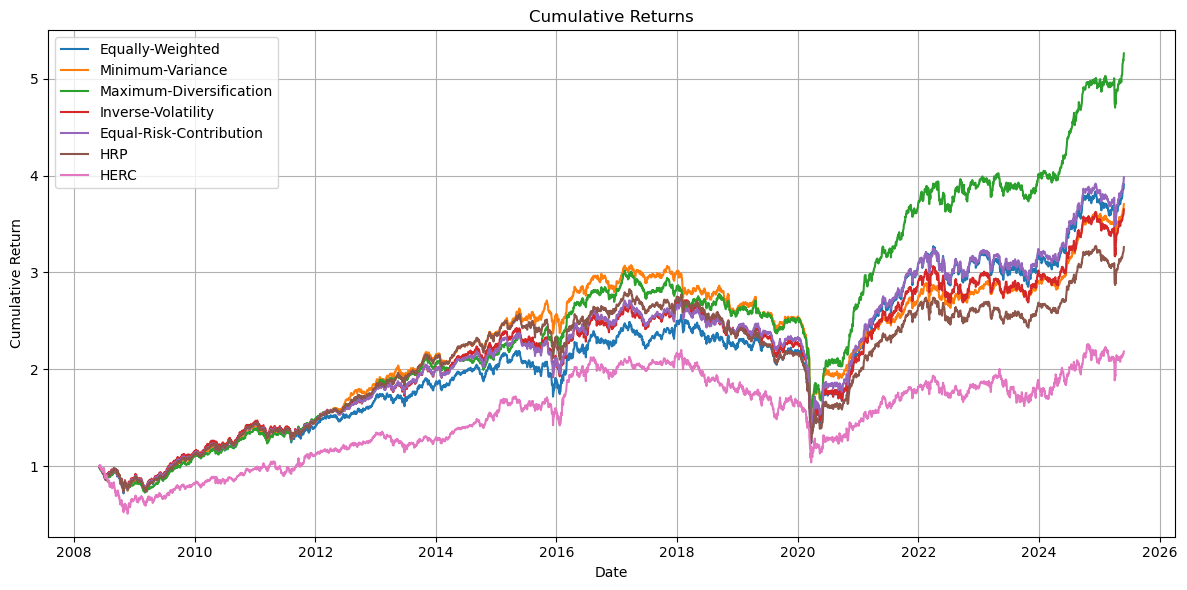

In [150]:
df_SP500_3jahre_shrinked["Date"] = pd.to_datetime(df_SP500_3jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_3jahre_shrinked = df_SP500_3jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_3jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [151]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
sharpe_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.662728         -1.415986                -1.640679   
2009          1.634533          2.846763                 2.539888   
2010          1.838356          2.684313                 2.441996   
2011         -0.065650          0.496776                 0.696618   
2012          2.282271          3.524717                 2.859371   
2013          0.887819          1.880527                 1.724273   
2014          0.983096          1.565964                 0.703853   
2015         -0.441398          0.778315                 0.797134   
2016          1.455534          1.330861                 1.896540   
2017          0.830074          0.563122                 0.176319   
2018         -0.791715         -1.376861                -0.892578   
2019         -0.354253         -0.372458                -0.351841   
20

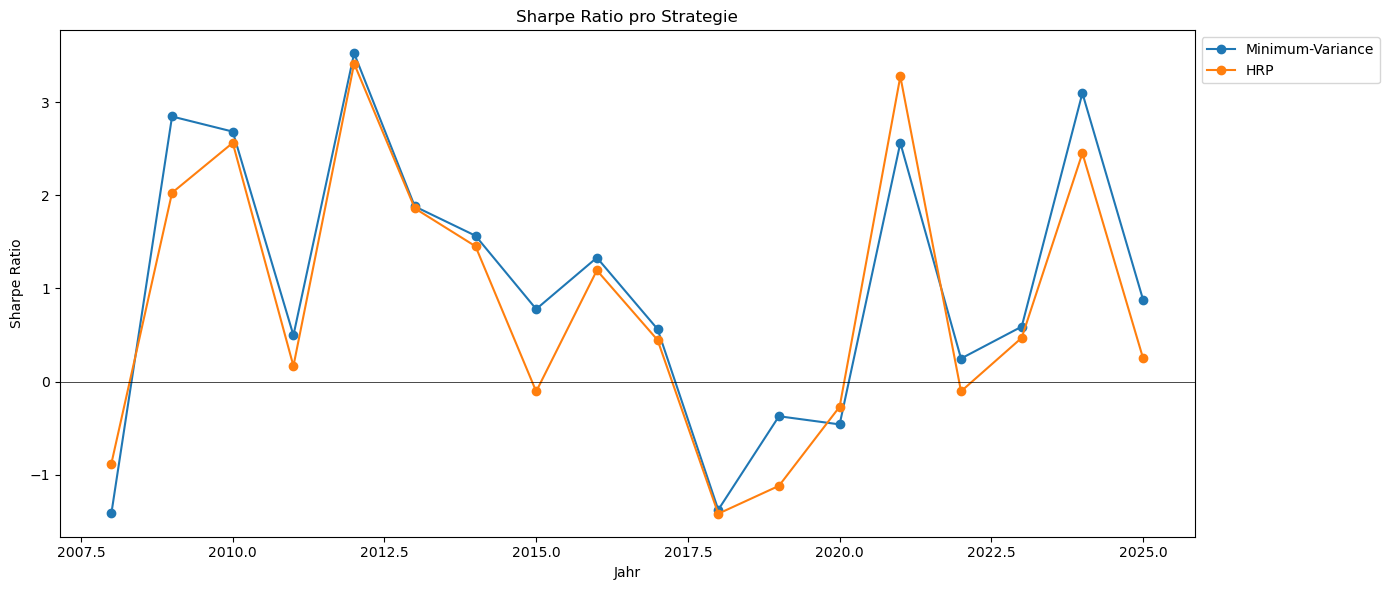

In [152]:
#Plotten der SR
strategien = sharpe_jahresweise_3jahre_shrinked.columns
years = sharpe_jahresweise_3jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_3jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_3jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [153]:
gesamt_sharpe_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(sharpe_annual_3jahre)

print(gesamt_sharpe_3jahre_shrinked)

Equally-Weighted           0.619015
Minimum-Variance           0.760375
Maximum-Diversification    0.910706
Inverse-Volatility         0.597690
Equal-Risk-Contribution    0.685597
HRP                        0.624634
HERC                       0.339666
dtype: float64


In [154]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
sortino_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.915300         -1.811195                -2.049784   
2009          2.469001          4.551166                 4.015863   
2010          2.748991          4.019355                 3.658483   
2011         -0.088524          0.674850                 0.953896   
2012          3.401434          6.082915                 4.855250   
2013          1.203144          2.714921                 2.454841   
2014          1.450084          2.349138                 1.012055   
2015         -0.580759          1.026093                 1.077874   
2016          2.208436          1.923538                 2.922877   
2017          1.248173          0.817331                 0.247624   
2018         -1.097885         -1.750993                -1.179322   
2019         -0.488597         -0.454314                -0.443854   
20

In [155]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(sortino_annual_3jahre)

print(gesamt_sortino_3jahre_shrinked)

Equally-Weighted           0.864996
Minimum-Variance           1.011811
Maximum-Diversification    1.234075
Inverse-Volatility         0.832482
Equal-Risk-Contribution    0.946440
HRP                        0.849876
HERC                       0.479034
dtype: float64


In [156]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
max_drawdown_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.280614         -0.250924                -0.244212   
2009         -0.192024         -0.107319                -0.131086   
2010         -0.075113         -0.043540                -0.053155   
2011         -0.137377         -0.122585                -0.113821   
2012         -0.043529         -0.031515                -0.029687   
2013         -0.076174         -0.083008                -0.065201   
2014         -0.083664         -0.052110                -0.064635   
2015         -0.215446         -0.126335                -0.120034   
2016         -0.079158         -0.076228                -0.053612   
2017         -0.110641         -0.060305                -0.096570   
2018         -0.140946         -0.148139                -0.113116   
2019         -0.125438         -0.121519                -0.124873   
20

In [157]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
max_drawdown_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.513253
Minimum-Variance          -0.507739
Maximum-Diversification   -0.492084
Inverse-Volatility        -0.536430
Equal-Risk-Contribution   -0.503124
HRP                       -0.562443
HERC                      -0.528197
dtype: float64>

In [158]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
calmar_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio))

calmar_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.725047         -1.018213                -1.170225   
2009          1.569383          3.227718                 2.669315   
2010          3.199084          5.475112                 4.536514   
2011         -0.119112          0.348196                 0.568465   
2012          4.566819          7.510388                 6.689475   
2013          1.267918          1.917326                 2.234556   
2014          1.072921          2.032947                 0.738520   
2015         -0.312279          0.600344                 0.671809   
2016          2.831036          1.667439                 3.761948   
2017          0.621960          0.578073                 0.103649   
2018         -0.652664         -0.846440                -0.754069   
2019         -0.281249         -0.299457                -0.284160   
20

In [159]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
calmar_total_2_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted           5.671651
Minimum-Variance           5.327779
Maximum-Diversification    8.662373
Inverse-Volatility         4.942912
Equal-Risk-Contribution    5.927663
HRP                        4.022015
HERC                       2.241144
dtype: float64>

In [160]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
var_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.026270         -0.024262                -0.022022   
2009         -0.017773         -0.010125                -0.012106   
2010         -0.011956         -0.008009                -0.008417   
2011         -0.013835         -0.009974                -0.009751   
2012         -0.008507         -0.005103                -0.006220   
2013         -0.013027         -0.008209                -0.007691   
2014         -0.008899         -0.006479                -0.007120   
2015         -0.014694         -0.009383                -0.010183   
2016         -0.013663         -0.009874                -0.009844   
2017         -0.008677         -0.006385                -0.007813   
2018         -0.011061         -0.009850                -0.010257   
2019         -0.009106         -0.007298                -0.008250   
20

In [161]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
var_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(value_at_risk_func)

var_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.013287
Minimum-Variance          -0.009103
Maximum-Diversification   -0.009735
Inverse-Volatility        -0.012864
Equal-Risk-Contribution   -0.011484
HRP                       -0.010589
HERC                      -0.017303
dtype: float64>

In [162]:
monthly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_3jahre_shrinked = monthly_returns_3jahre_shrinked.apply(value_at_risk_func)

monthly_var_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.040938
Minimum-Variance          -0.045173
Maximum-Diversification   -0.040255
Inverse-Volatility        -0.043503
Equal-Risk-Contribution   -0.038646
HRP                       -0.045766
HERC                      -0.053093
dtype: float64>

In [163]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
es_jahresweise_3jahre_shrinked = df_SP500_3jahre_shrinked.groupby(df_SP500_3jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_3jahre_shrinked.info

<bound method DataFrame.info of       Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2008         -0.037870         -0.031604                -0.030687   
2009         -0.021705         -0.013029                -0.015358   
2010         -0.016394         -0.011152                -0.011860   
2011         -0.018698         -0.014041                -0.014438   
2012         -0.011562         -0.007187                -0.007758   
2013         -0.017198         -0.011550                -0.011851   
2014         -0.012774         -0.008558                -0.009375   
2015         -0.020881         -0.015964                -0.016157   
2016         -0.019639         -0.013842                -0.013750   
2017         -0.011165         -0.008721                -0.009697   
2018         -0.014596         -0.014553                -0.013911   
2019         -0.012843         -0.013655                -0.014132   
20

In [164]:
df_SP500_3jahre_shrinked.index = pd.to_datetime(df_SP500_3jahre_shrinked.index)
es_total_3jahre_shrinked = df_SP500_3jahre_shrinked.apply(expected_shortfall)

es_total_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.020998
Minimum-Variance          -0.015843
Maximum-Diversification   -0.016595
Inverse-Volatility        -0.020686
Equal-Risk-Contribution   -0.018896
HRP                       -0.018071
HERC                      -0.026281
dtype: float64>

In [165]:
monthly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_3jahre_shrinked = monthly_returns_3jahre_shrinked.apply(expected_shortfall)

monthly_es_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.089700
Minimum-Variance          -0.081934
Maximum-Diversification   -0.081110
Inverse-Volatility        -0.088854
Equal-Risk-Contribution   -0.086441
HRP                       -0.087953
HERC                      -0.100175
dtype: float64>

In [166]:
yearly_returns_3jahre_shrinked = df_SP500_3jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_3jahre_shrinked  = yearly_returns_3jahre_shrinked.apply(expected_shortfall)

yearly_es_3jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.128211
Minimum-Variance          -0.163022
Maximum-Diversification   -0.183730
Inverse-Volatility        -0.112355
Equal-Risk-Contribution   -0.126244
HRP                       -0.135111
HERC                      -0.337337
dtype: float64>

In [167]:
#Zusammenfassung der Metriken
Zusammenfassung_3jahre_shrinked = pd.concat([gesamt_sharpe_3jahre_shrinked, gesamt_sortino_3jahre_shrinked, max_drawdown_total_3jahre_shrinked, calmar_total_2_3jahre_shrinked, monthly_var_3jahre_shrinked, monthly_es_3jahre_shrinked], axis=1)
Zusammenfassung_3jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_3jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.619015  0.864996     -0.513253  5.671651 -0.040938   
Minimum-Variance         0.760375  1.011811     -0.507739  5.327779 -0.045173   
Maximum-Diversification  0.910706  1.234075     -0.492084  8.662373 -0.040255   
Inverse-Volatility       0.597690  0.832482     -0.536430  4.942912 -0.043503   
Equal-Risk-Contribution  0.685597  0.946440     -0.503124  5.927663 -0.038646   
HRP                      0.624634  0.849876     -0.562443  4.022015 -0.045766   
HERC                     0.339666  0.479034     -0.528197  2.241144 -0.053093   

                               ES  
Equally-Weighted        -0.089700  
Minimum-Variance        -0.081934  
Maximum-Diversification -0.081110  
Inverse-Volatility      -0.088854  
Equal-Risk-Contribution -0.086441  
HRP                     -0.087953  
HERC                    -0.100175  
